In [1]:
import numpy as np
import pandas as pd
import torch
import os
import time 
import copy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set(font_scale=1)

from skbio import TreeNode
from SimulationResult import SimulationResult

/Users/sitarapersad/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Singleton Estimation

We want to estimate the number of singletons that we can expect to have for skeleton tree reconstruction

<b> Variables to Consider:</b>

- num_targets - number of potential target sites 
- mut_rate - mutation rate per target site
- edit_distribution - distribution over potential edits per target site

<hr>

<b> Simulation Formulation </b>

We begin each simulation with one cell, representing the fertilised egg, that has all its targets in an unmutated state. The initial cell then undergoes a series of cell divisions (d), growing into a population of N cells, where $N=2^d$. Following each cell division, each unmutated target can mutate (with a given probability μd) to one of several possible mutated states. Once a target is mutated, it can no longer change, either to revert to the unmutated state or to transit to a new state.


<b> Useful References </b>

<sub> [1]https://elifesciences.org/articles/40292


</sub>

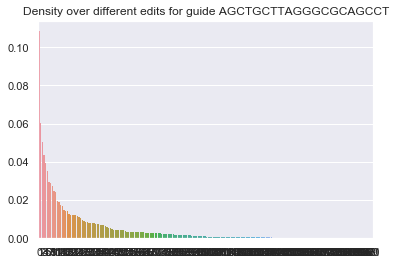

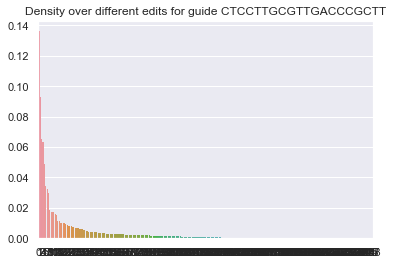

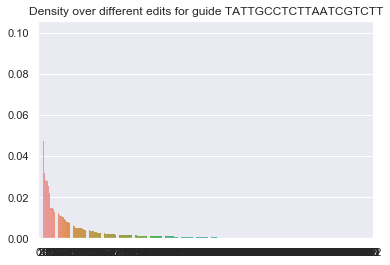

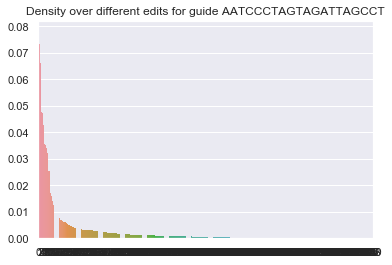

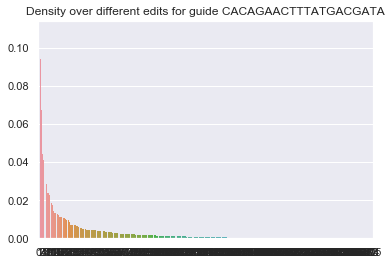

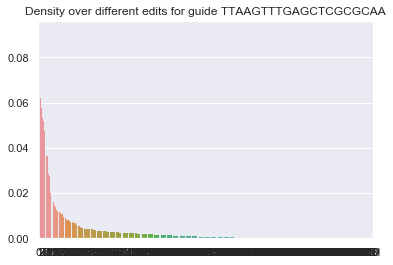

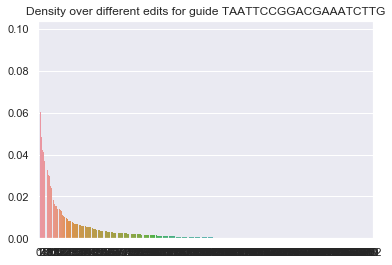

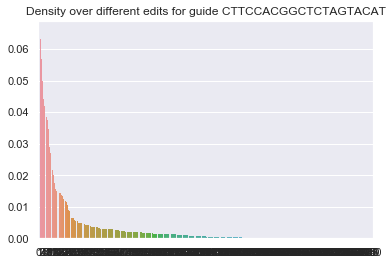

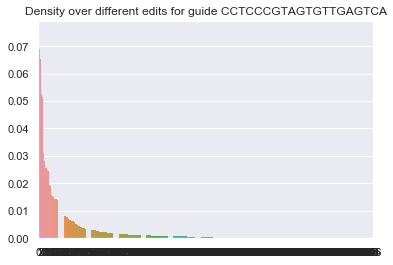

In [2]:
## How many cells does the real data end up with?
## Did this seed from one cell? 

import pickle
with open('d21_indel_distributions.p', 'rb') as f:
    indel_distributions = pickle.load(f)

slow_guides = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'TATTGCCTCTTAATCGTCTT']
medium_guides = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TTAAGTTTGAGCTCGCGCAA']
fast_guides = ['TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']

for li in [slow_guides, medium_guides, fast_guides]:
    for guide in li:
        dist = indel_distributions[guide]
        try:
            del dist['']
        except KeyError:
            pass
        distvals = np.array(sorted(list(dist.values()), reverse=True))
        distvals = distvals/distvals.sum()
        plt.figure()
        sns.barplot(np.arange(len(distvals)), distvals, linewidth=0)
        plt.title('Density over different edits for guide {0}'.format(guide))
        plt.show()
        plt.close()

# Estimate the mutation probability

# For a given site E_i[%] = E_{i-1}[%] + p(1-E_{i-1}[%])
# E_i = 1-q^i, where q = 1-p 
# Sanity check: 
# E_0 = 1-(1-p)^0 = 0 
# E_1 = 1-(1-p) = p 

# We can choose to use a combination of varying speed guides 

# 4, 7, 14, 21 days -> 4 generations, 7 generations etc (24 hrs for cell cycle?)

# How many generations does 1 day correspond to?
# Slow guides:
slow = [0.09, 0.15, 0.29, 0.4]

# Medium guides
medium = [0.15, 0.35, 0.6, 0.75]

# Fast guides
fast = [0.75, 0.9, 0.95, 0.96]




In [3]:
gens = [4,7,14,21]
print('\nSlow')
p_avg = 0
for i, x in enumerate(slow):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)

print('\nMedium')
p_avg = 0
for i, x in enumerate(medium):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)

print('\nFast')
p_avg = 0
for i, x in enumerate(fast):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)    

""" 
Questions
1. tree or forest
2. are the rates based on isolating a clone or from a forest
3. yosef lab was a single tree?? no

try this instead: 
start with many roots (a forest)

reproduction rate varying / same ?vfr 

"""


Slow
0.02330188829047808
0.02294954933760507
0.02416678505263603
0.024031560532588148
Avg
0.02361244580332683

Medium
0.03981541059581217
0.05968505934696777
0.06335350204906998
0.0638822575463951
Avg
0.056684057384561254

Fast
0.2928932188134524
0.28031432699884795
0.19263617565013524
0.14211035031316765
Avg
0.22698851794390082


' \nQuestions\n1. tree or forest\n2. are the rates based on isolating a clone or from a forest\n3. yosef lab was a single tree?? no\n\ntry this instead: \nstart with many roots (a forest)\n\nreproduction rate varying / same ?vfr \n\n'

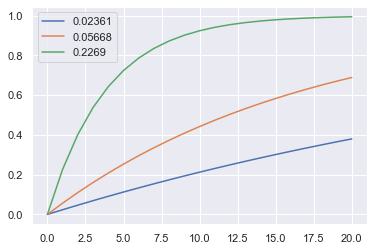

In [4]:
plt.figure()
for p in [0.02361, 0.05668, 0.2269]:
    q = 1-p
    plt.plot(np.arange(21), 1-q**np.arange(21), label=p)
plt.legend()
plt.show()
plt.close()

rate = {}
rate['slow'] = 0.02361
rate['medium'] = 0.05668
rate['fast'] = 0.2269

## Perform a lineage tracing experiment 

In [5]:
from crispr_lib import lineageSimulation

In [73]:
slow_guides = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'TATTGCCTCTTAATCGTCTT']
medium_guides = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TTAAGTTTGAGCTCGCGCAA']
fast_guides = ['TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']

ssm = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT','AATCCCTAGTAGATTAGCCT']
smm = ['AGCTGCTTAGGGCGCAGCCT', 'AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA']
ssf = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'CCTCCCGTAGTGTTGAGTCA']
smf = ['AGCTGCTTAGGGCGCAGCCT', 'AATCCCTAGTAGATTAGCCT', 'CCTCCCGTAGTGTTGAGTCA']
sff = ['AGCTGCTTAGGGCGCAGCCT', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']
mmf = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TAATTCCGGACGAAATCTTG']
mff = ['AATCCCTAGTAGATTAGCCT', 'TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT']


results = {'Guides':[], 'Num_Distinct_Edits':[], 
           'Min_depths':[], 'Num_Mutations':[],
           'Recurring_Characters':[],  
           'Recurring_Characters_%':[],
           'Recurring_Mutations' : [],
           'Recurring_Mutations_%': []
          }

subsampled_results = {'Guides':[], 'Total_Mutations':[], 'Distinct_Mutations':[], 'Recurring_Mutations':[], 'Recurring_Mutations_%':[], 'Unique_Cells': [] }

timers = {}

lists_of_guides = [slow_guides, ssm, smm, ssf, smf, sff, medium_guides, mmf, mff, fast_guides]
labels = ['sss','ssm','smm','ssf','smf','sff', 'mmm', 'mmf','mff', 'fff']
verbose = False
tree_depth = 18
num_runs = 3
n_subsample = 10000
num_arrays = 10

debug = True
compute_tree = False

if debug:
    lists_of_guides = [smf]
    labels = ['smf']
    tree_depth = 10
    num_runs = 3
    n_subsample = 10000
    num_arrays = 10

Label: smf
List of targets:  [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (5, 0), (5, 1), (5, 2), (6, 0), (6, 1), (6, 2), (7, 0), (7, 1), (7, 2), (8, 0), (8, 1), (8, 2), (9, 0), (9, 1), (9, 2)]
Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19


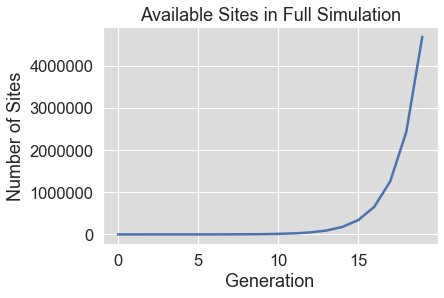

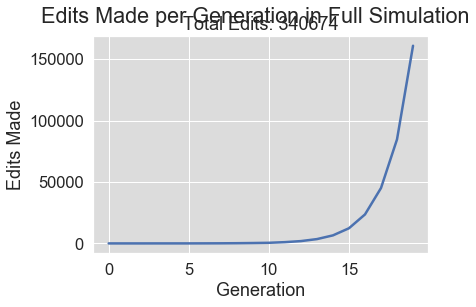

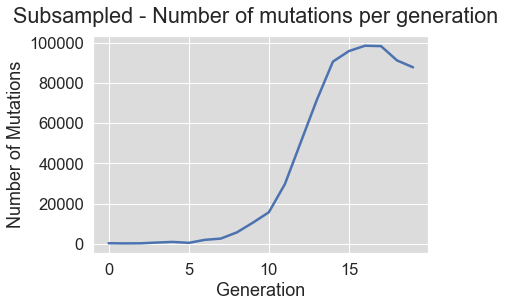

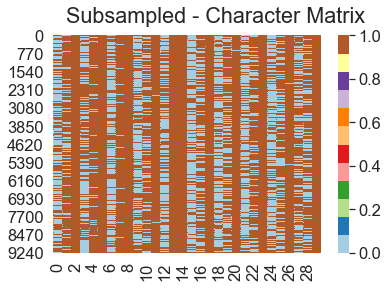

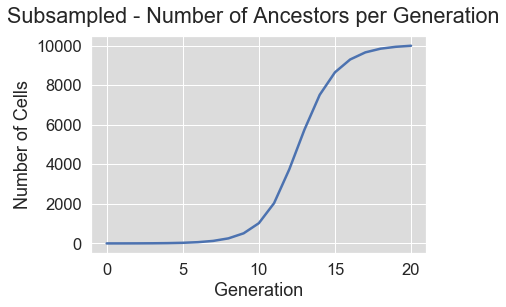

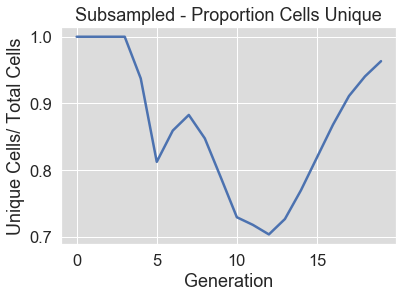

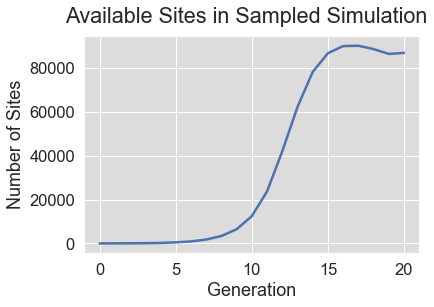

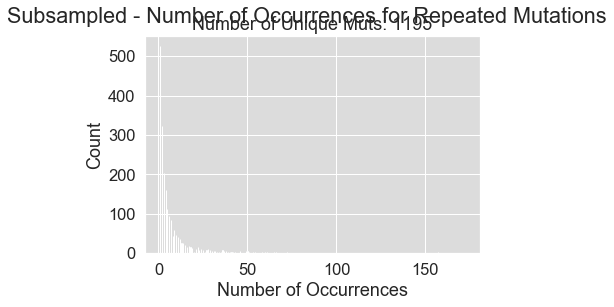

(10000, 30)
Time 1: 0.16369199752807617
Compute dictionary: 52.62823009490967
Conflict matrix is symmetric?  True
Total time: 52.94169330596924
Number of true recurrent muts:  2134
Number of detected recurrent muts:  2522
Number of true recurrent muts not detected: 6 with prevalence [10000, 10000, 10000, 10000, 10000, 10000]


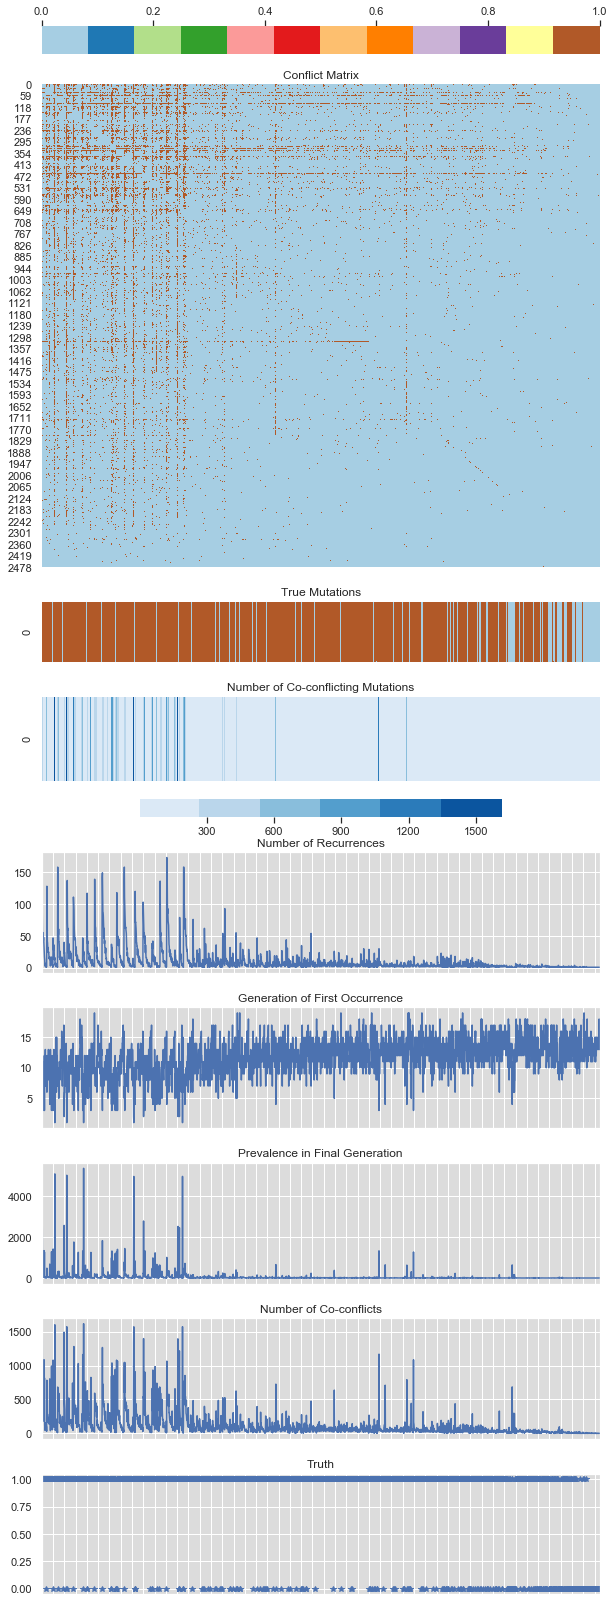

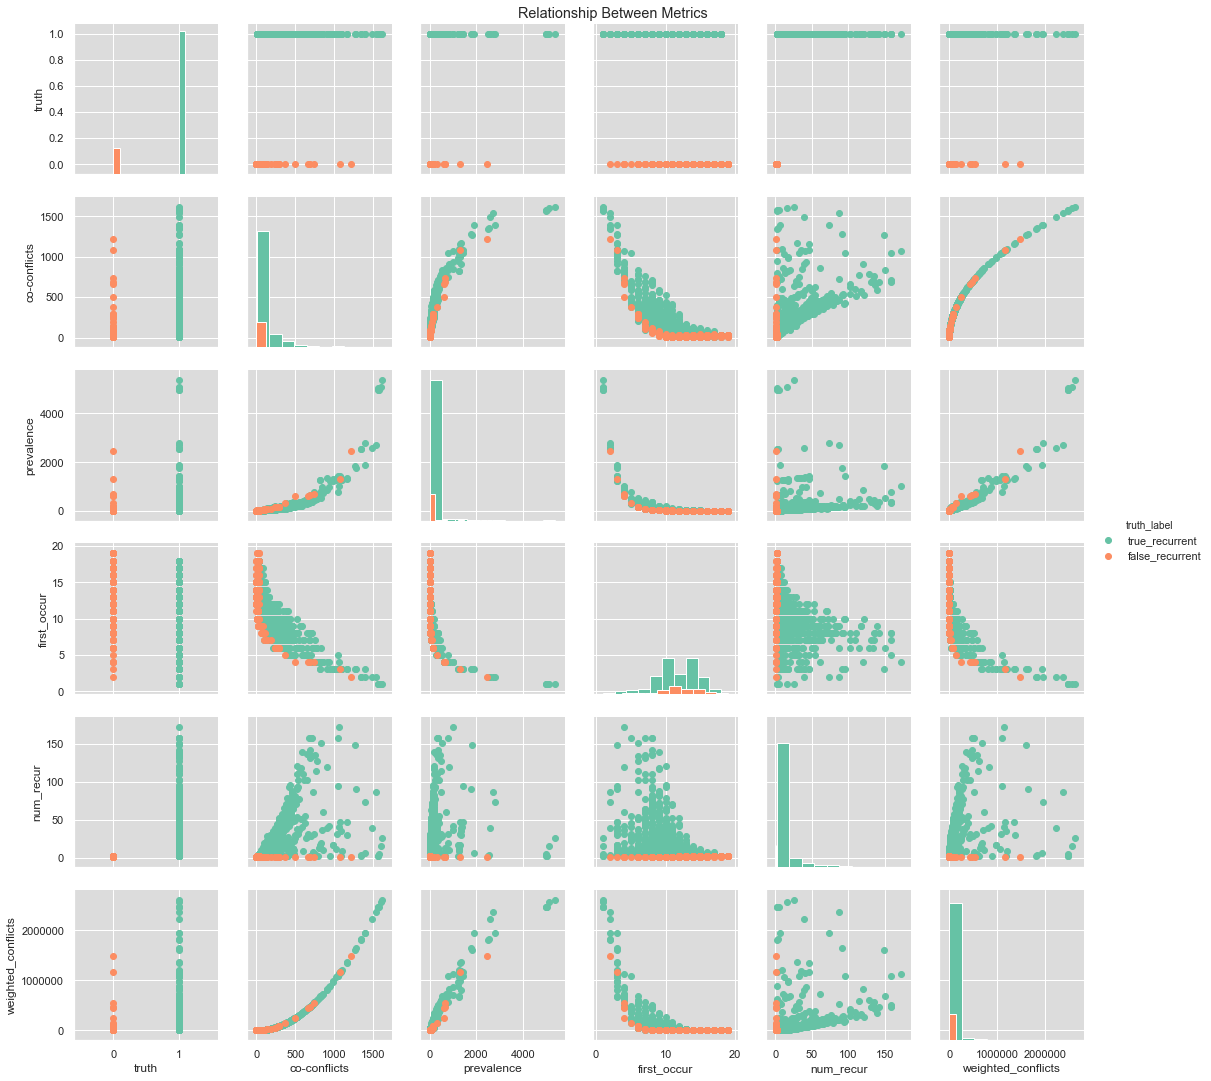

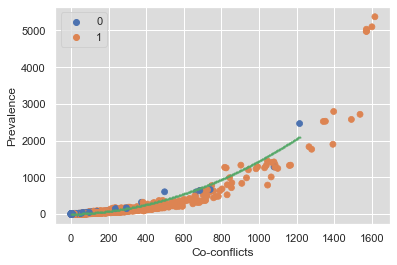

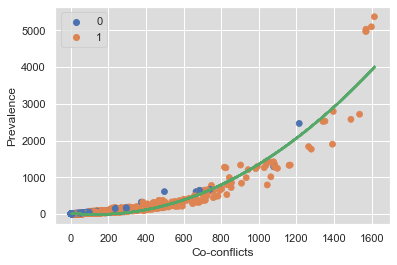

Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19


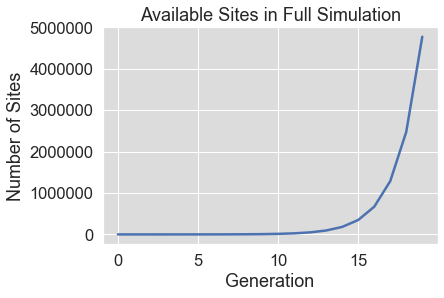

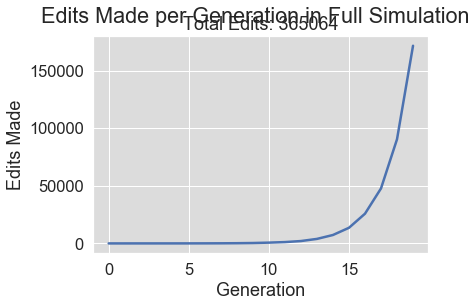

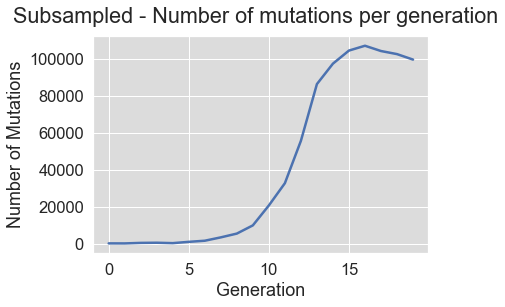

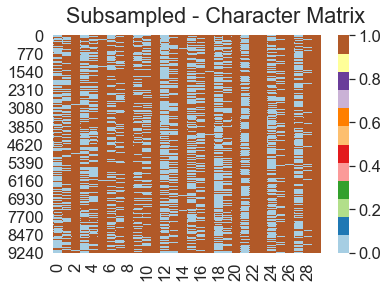

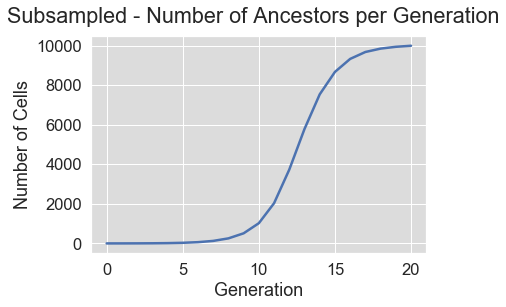

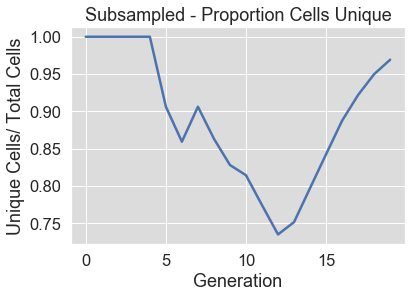

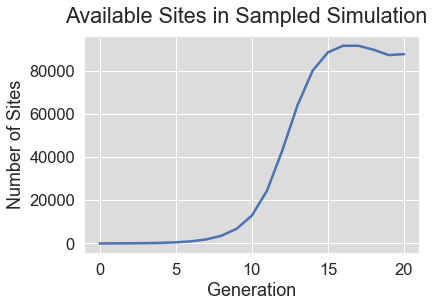

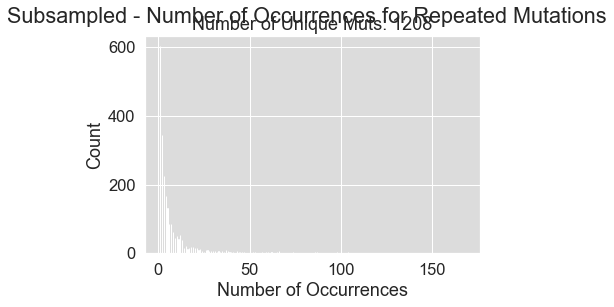

(10000, 30)
Time 1: 0.17399191856384277
Compute dictionary: 76.72445917129517
Conflict matrix is symmetric?  True
Total time: 77.0354380607605
Number of true recurrent muts:  2325
Number of detected recurrent muts:  2710
Number of true recurrent muts not detected: 3 with prevalence [10000, 10000, 10000]


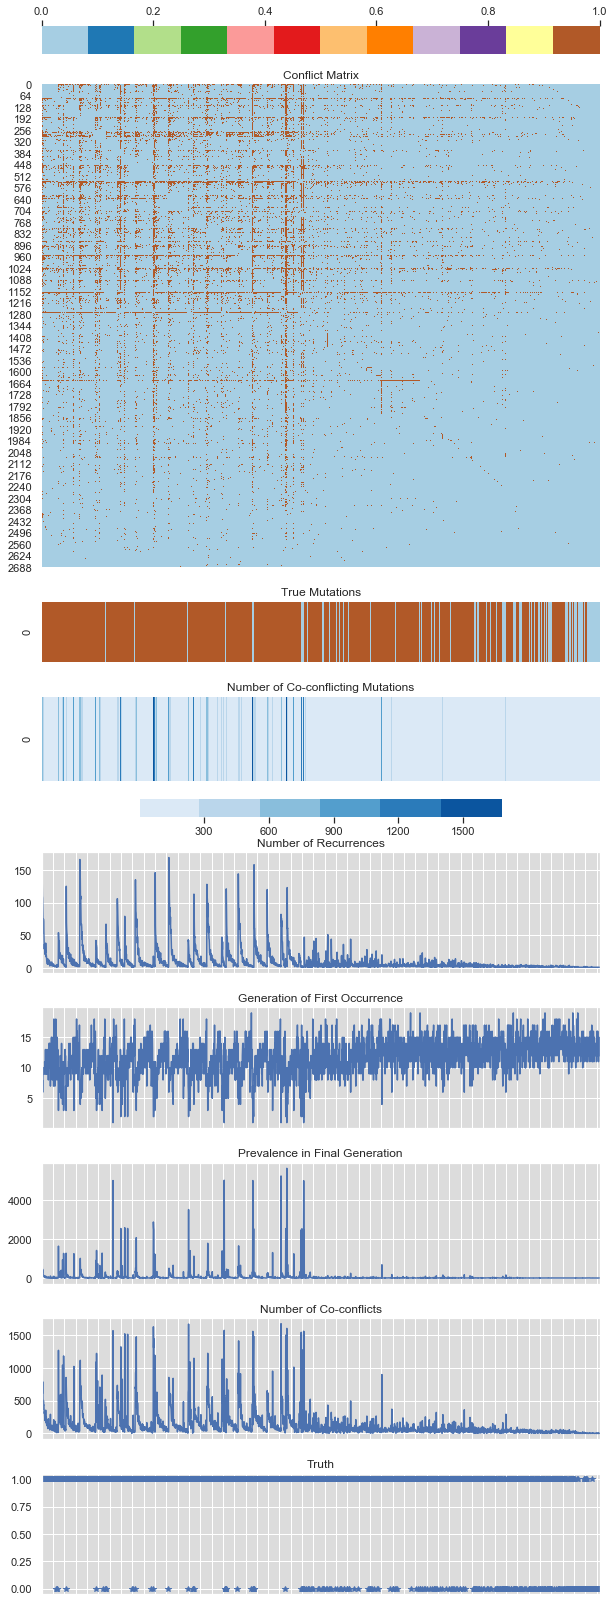

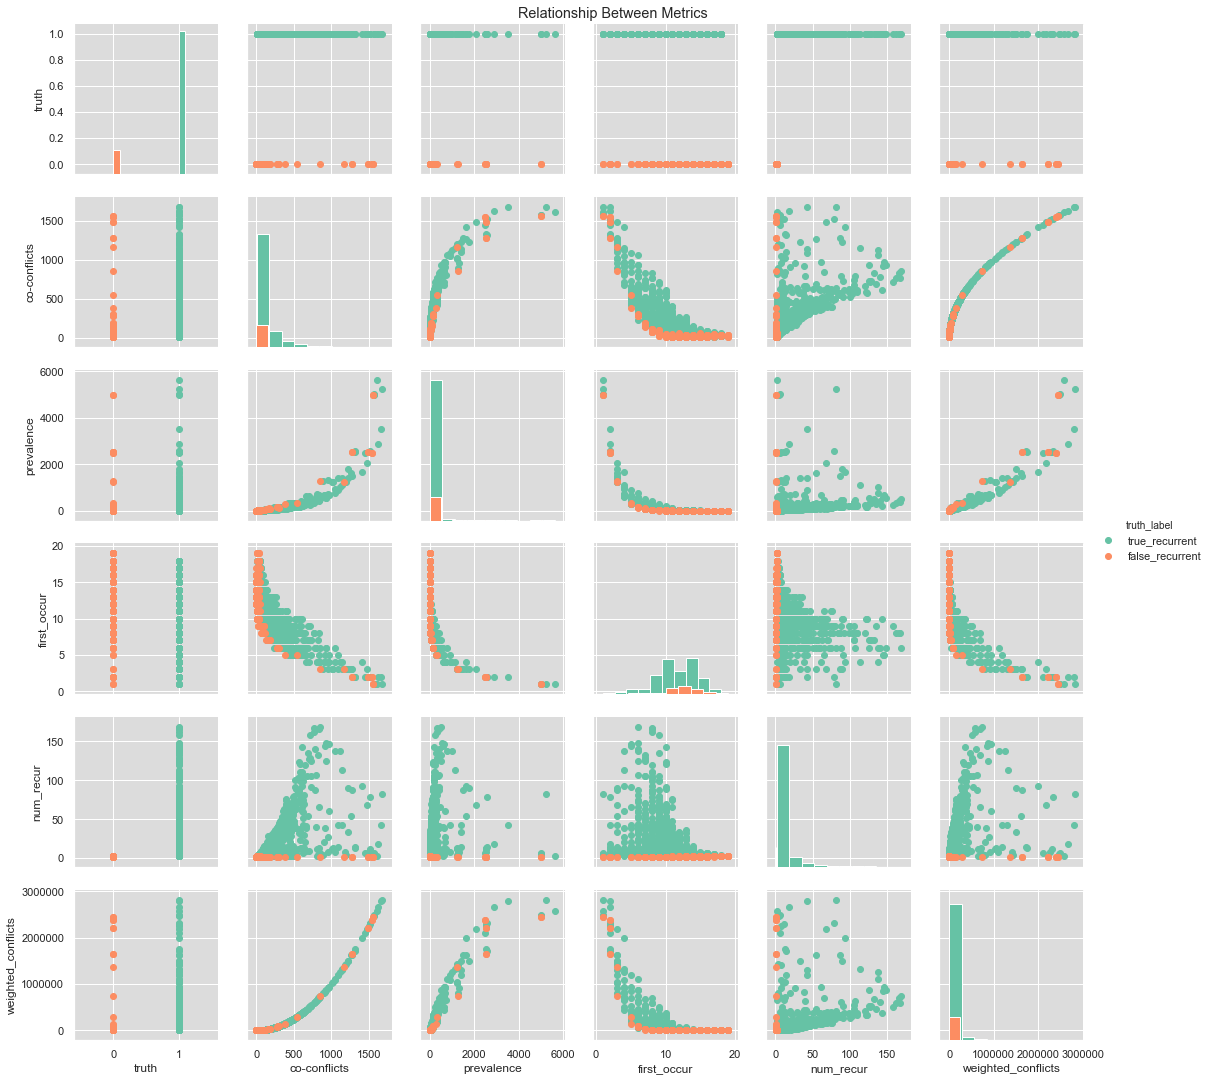

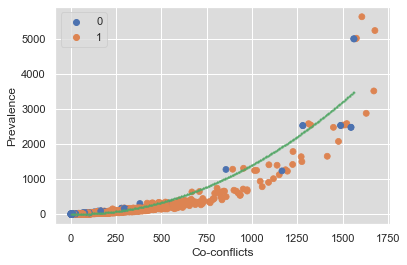

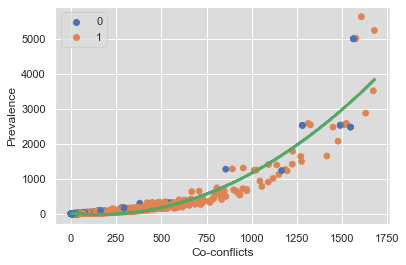

Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19


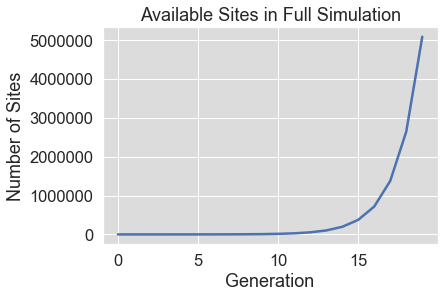

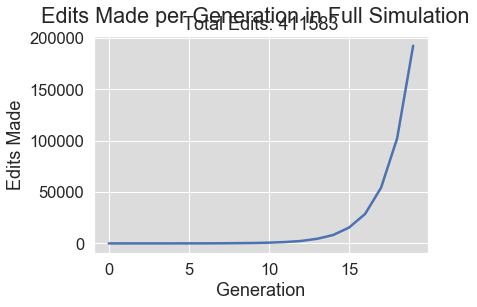

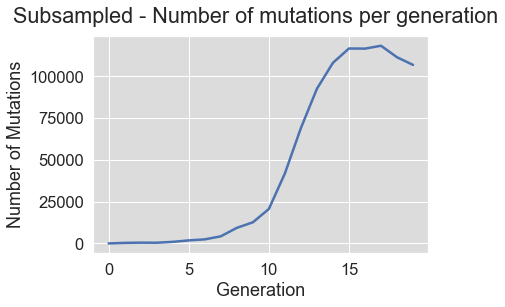

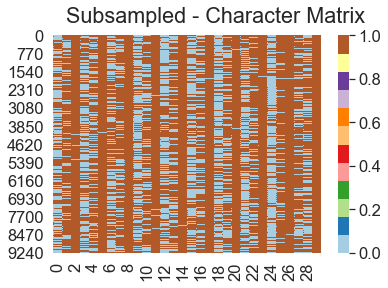

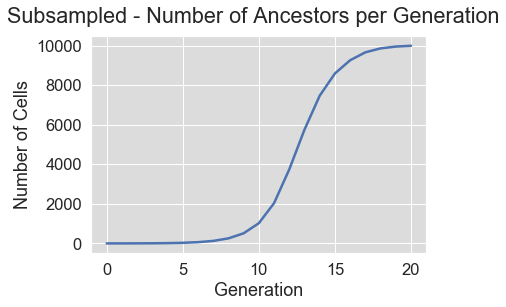

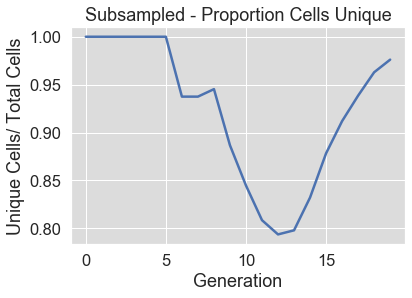

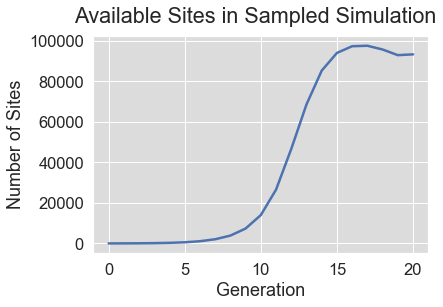

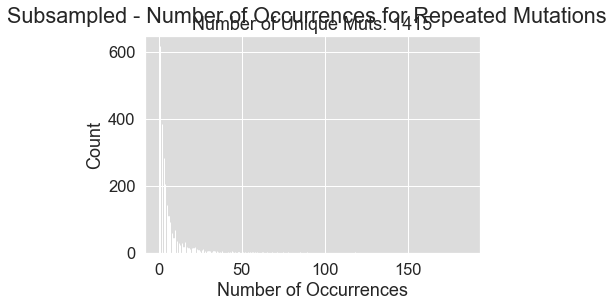

(10000, 30)
Time 1: 0.1853930950164795
Compute dictionary: 72.90326714515686
Conflict matrix is symmetric?  True
Total time: 73.31879115104675
Number of true recurrent muts:  2582
Number of detected recurrent muts:  3070
Number of true recurrent muts not detected: 0 with prevalence []


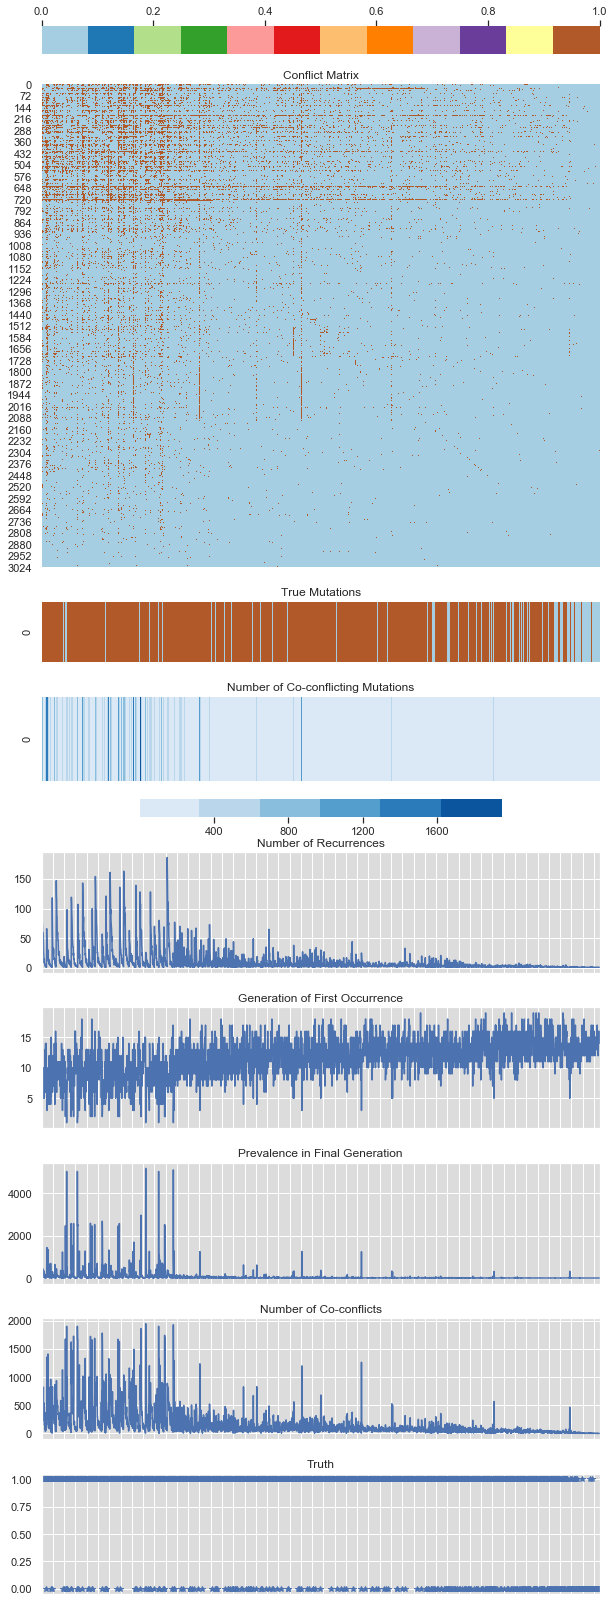

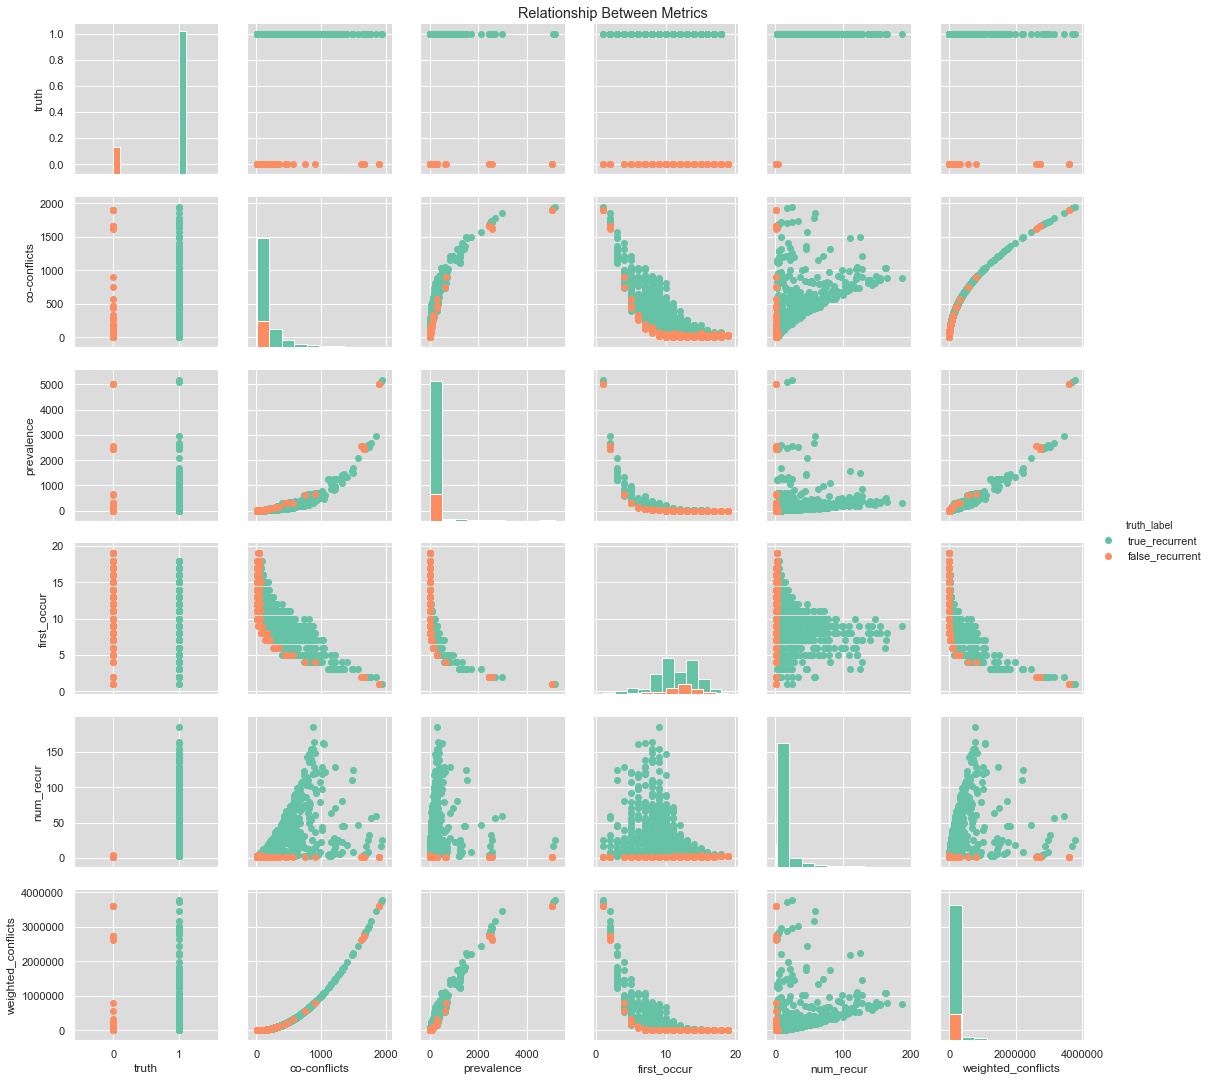

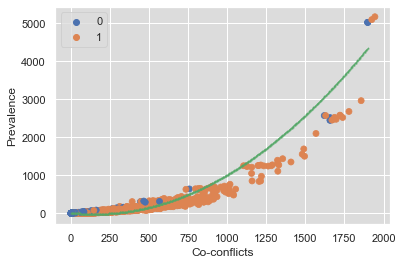

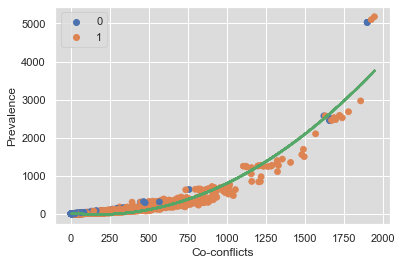

Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16


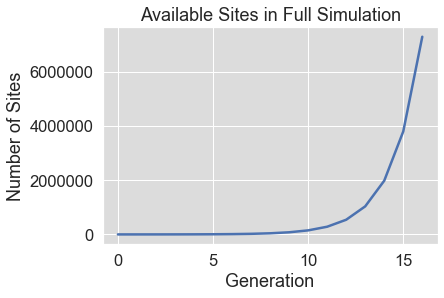

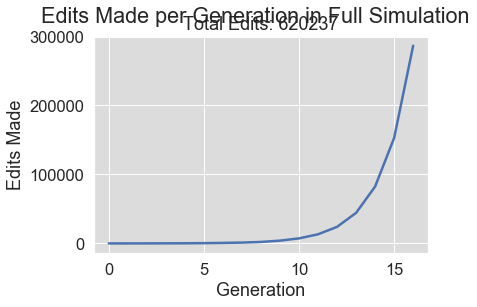

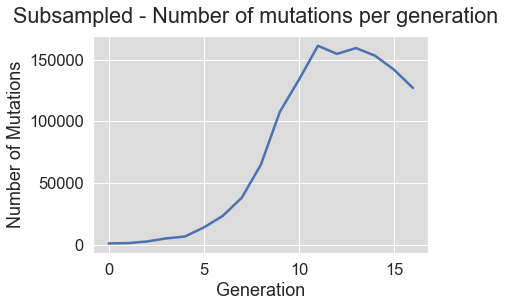

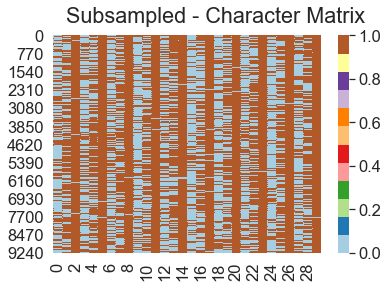

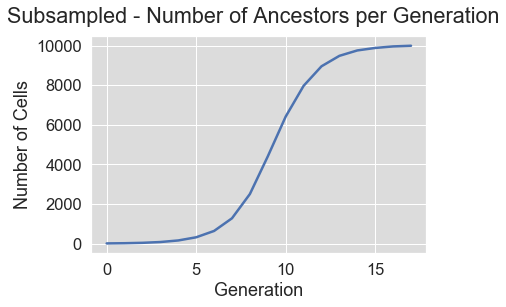

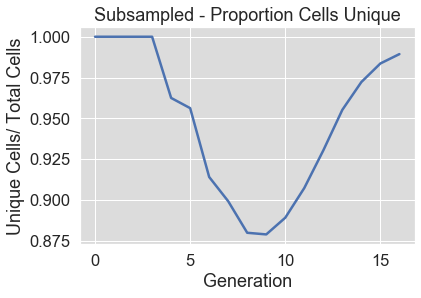

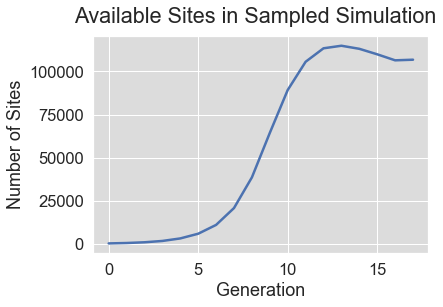

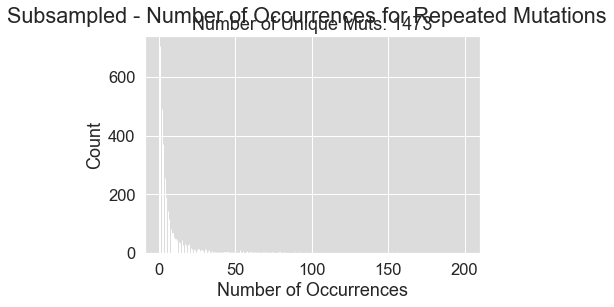

(10000, 30)
Time 1: 0.22481918334960938
Compute dictionary: 122.6779670715332
Conflict matrix is symmetric?  True
Total time: 123.40428423881531
Number of true recurrent muts:  3260
Number of detected recurrent muts:  3797
Number of true recurrent muts not detected: 0 with prevalence []


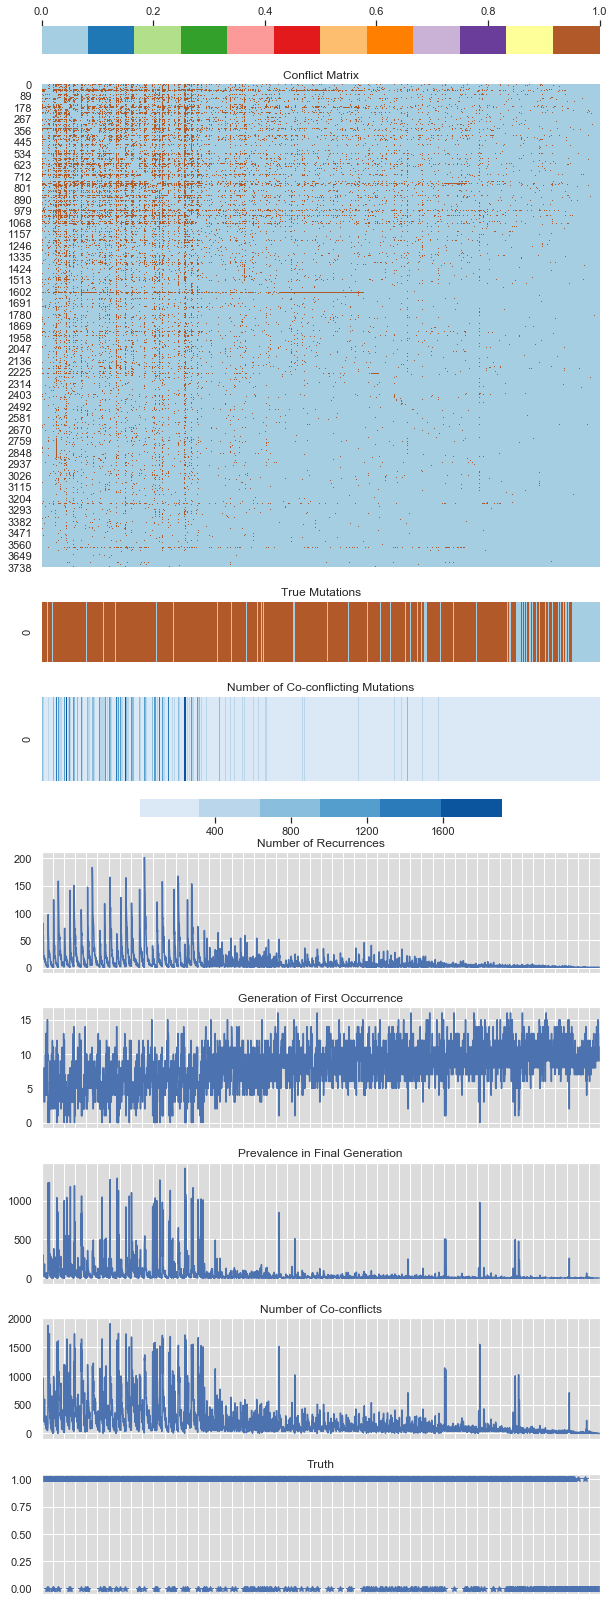

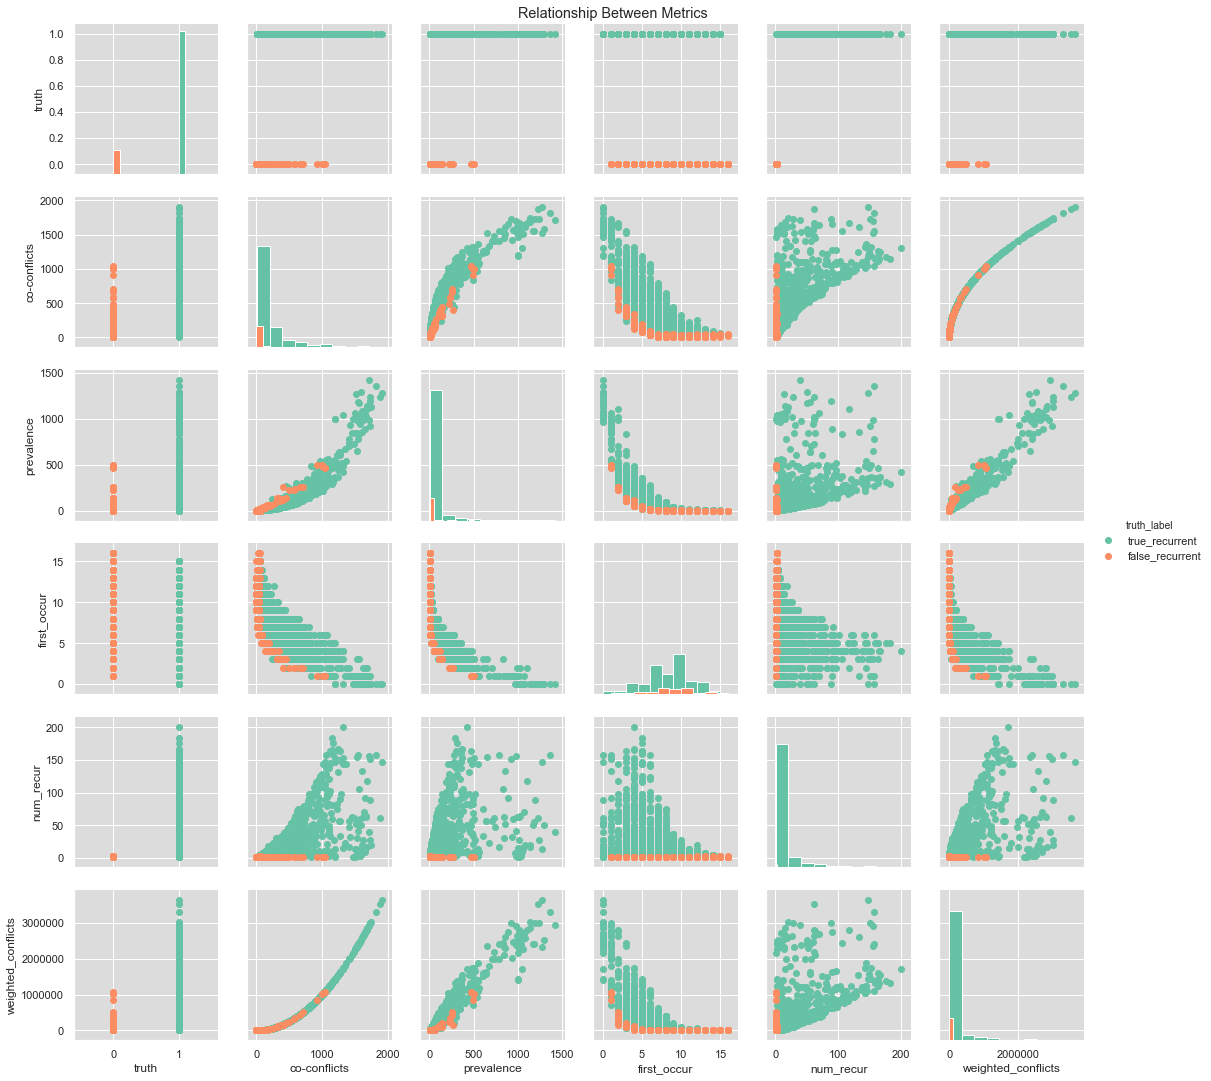

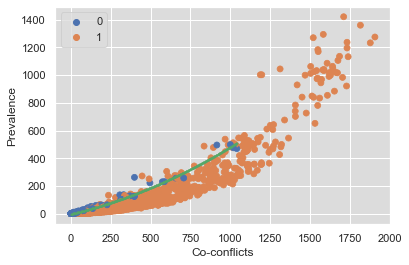

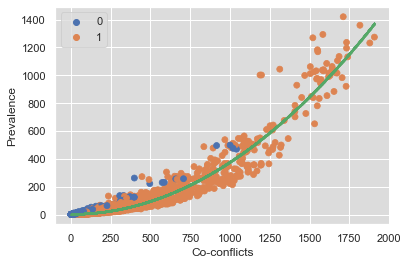

Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16


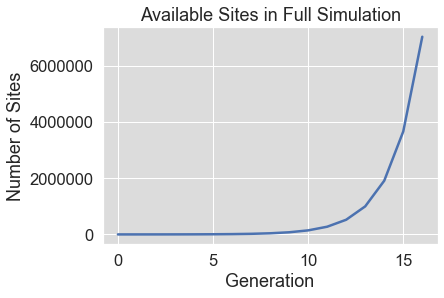

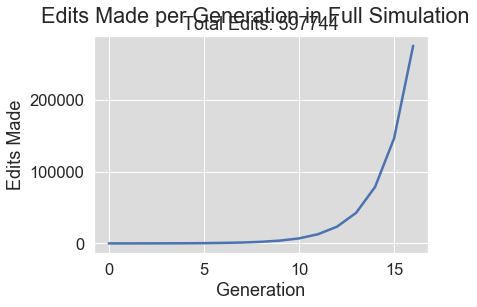

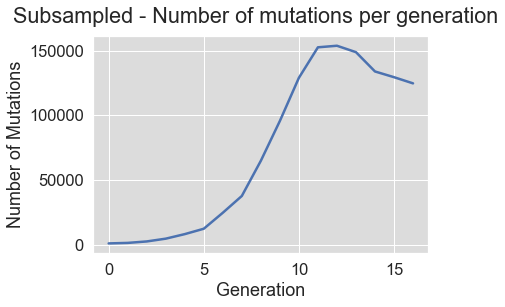

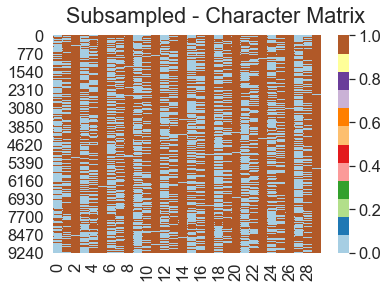

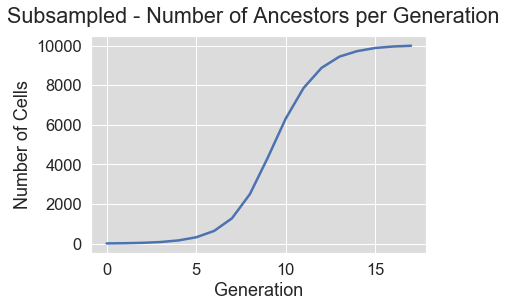

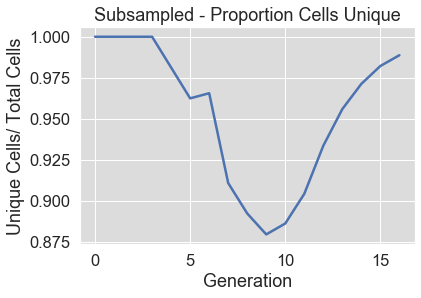

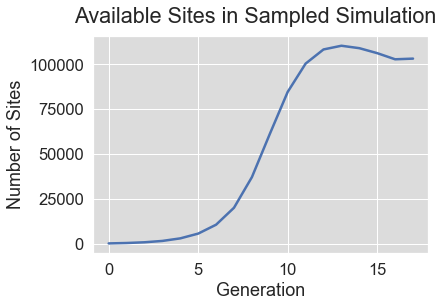

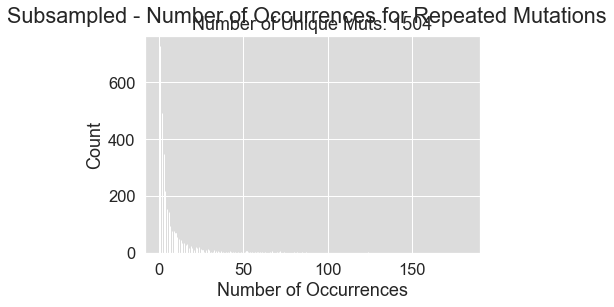

(10000, 30)
Time 1: 0.23276185989379883
Compute dictionary: 114.31903266906738
Conflict matrix is symmetric?  True
Total time: 114.96661877632141
Number of true recurrent muts:  3180
Number of detected recurrent muts:  3680
Number of true recurrent muts not detected: 0 with prevalence []


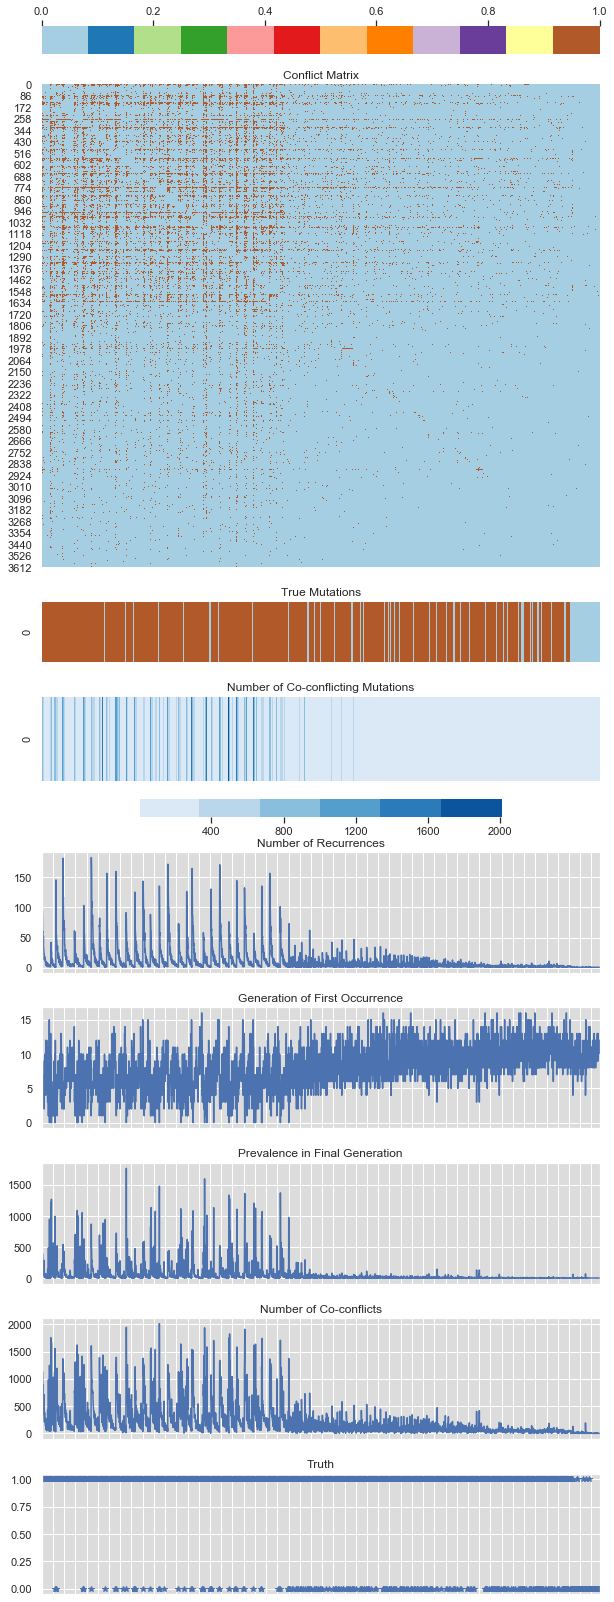

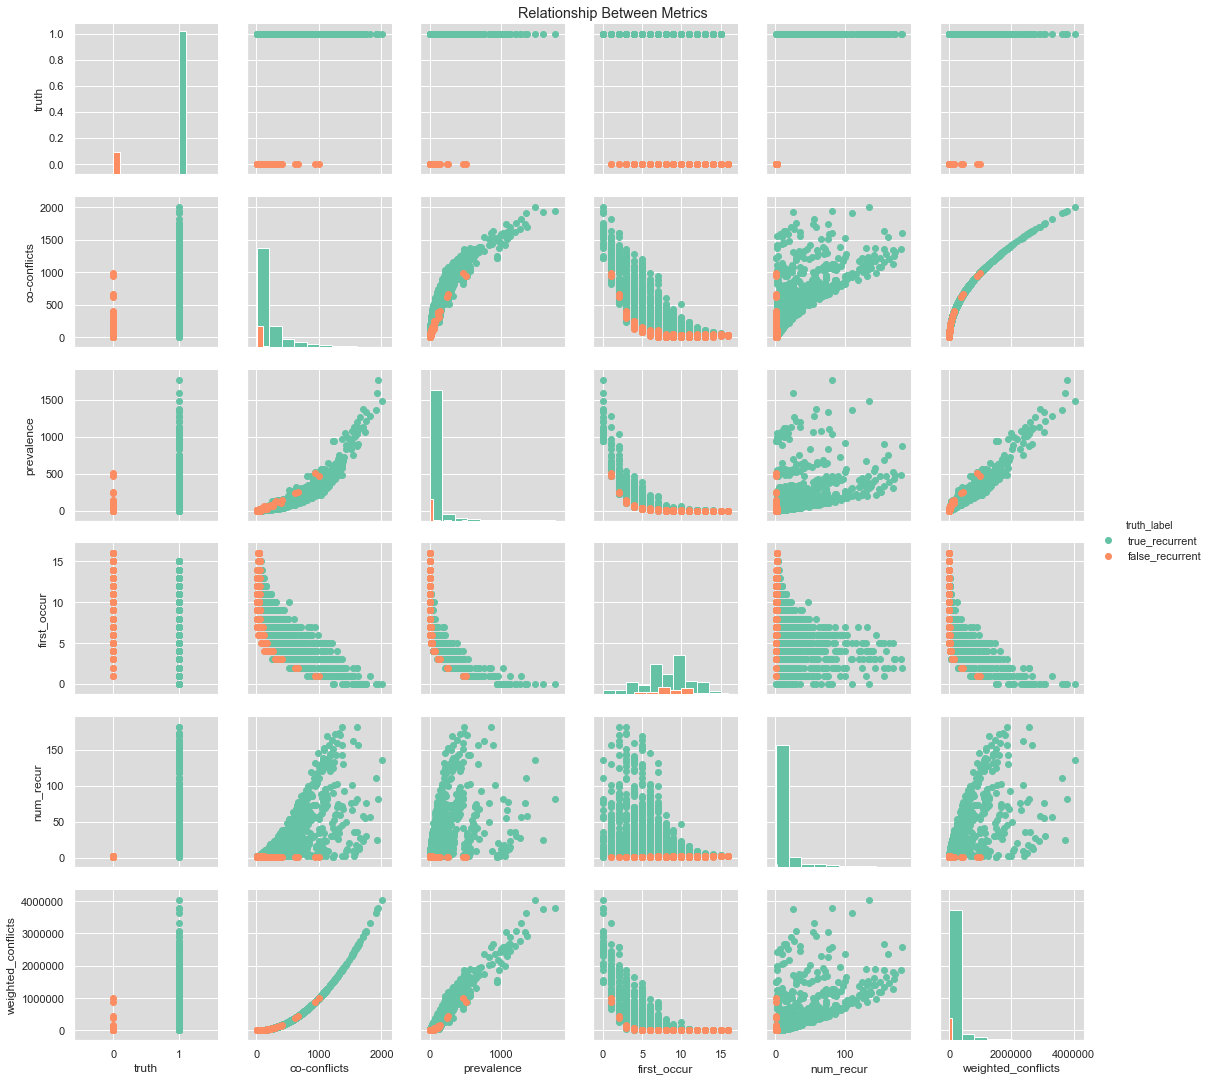

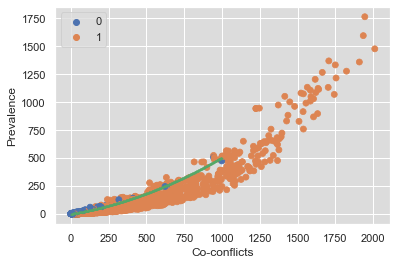

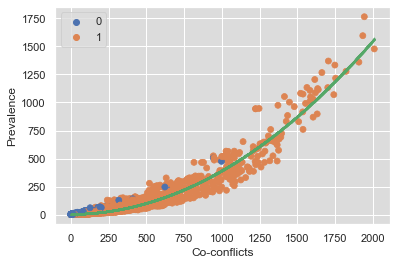

Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16


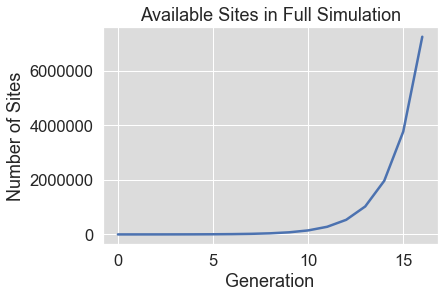

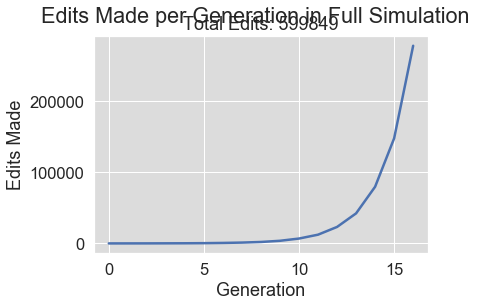

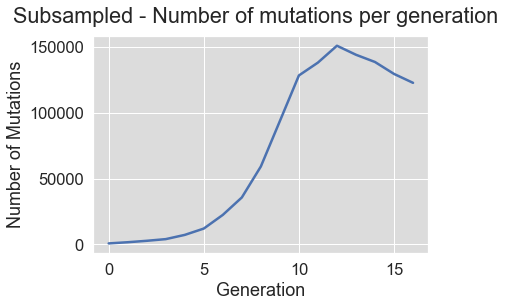

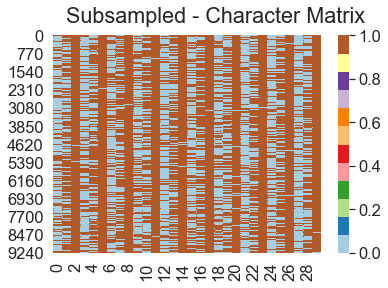

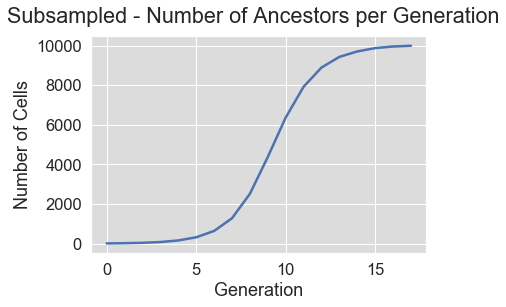

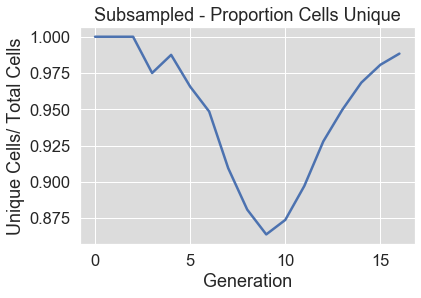

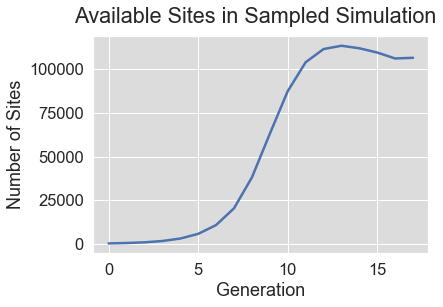

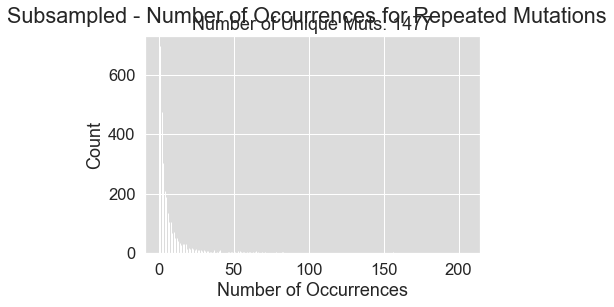

(10000, 30)
Time 1: 0.22741413116455078
Compute dictionary: 91.1221489906311
Conflict matrix is symmetric?  True
Total time: 91.74358677864075
Number of true recurrent muts:  3088
Number of detected recurrent muts:  3607
Number of true recurrent muts not detected: 0 with prevalence []


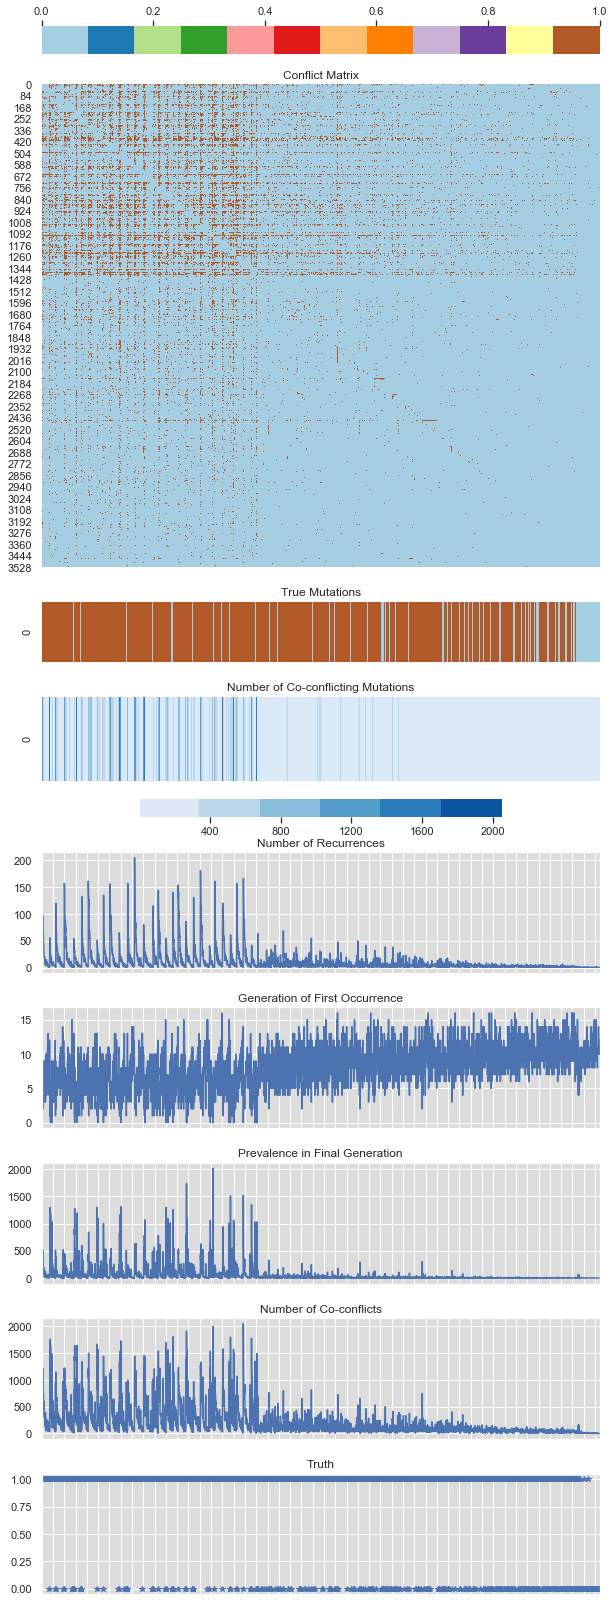

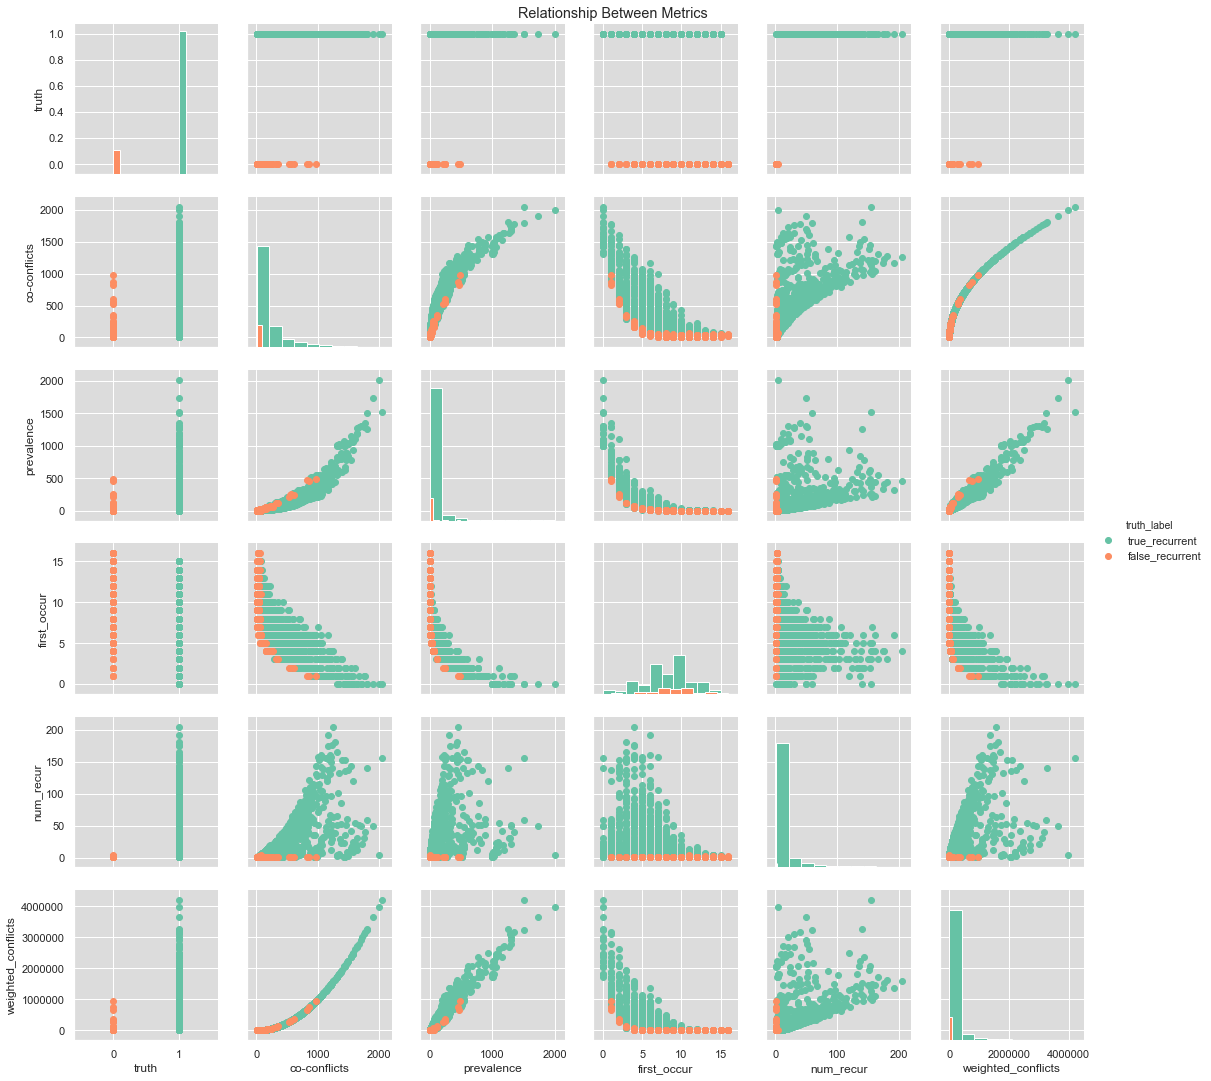

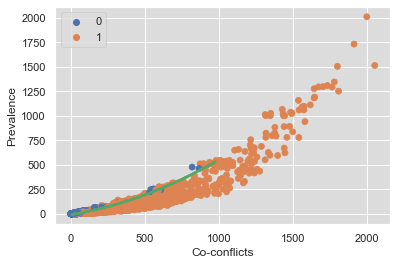

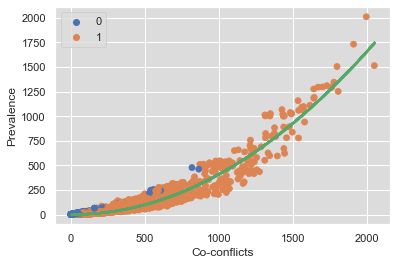

Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12


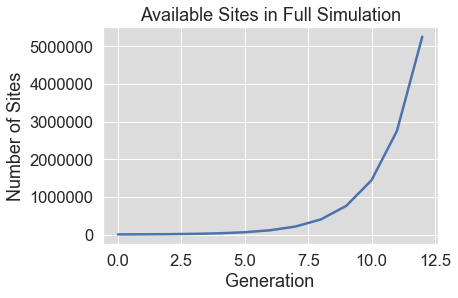

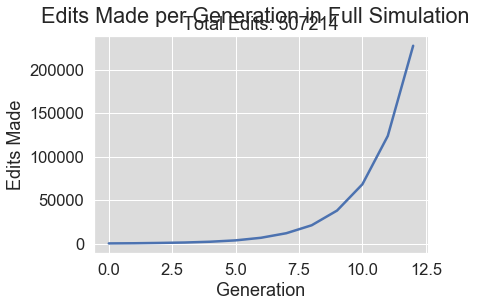

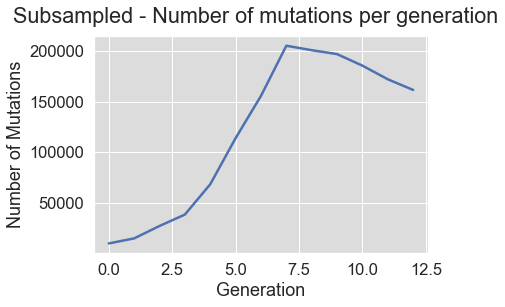

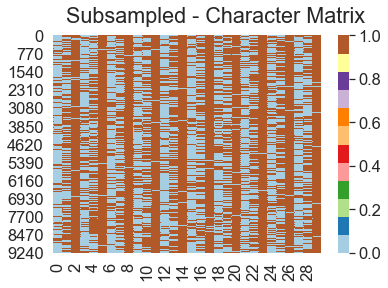

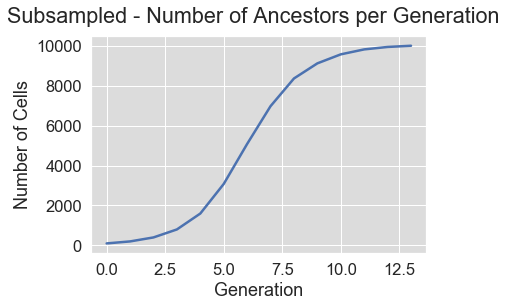

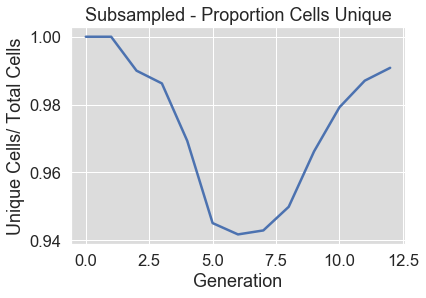

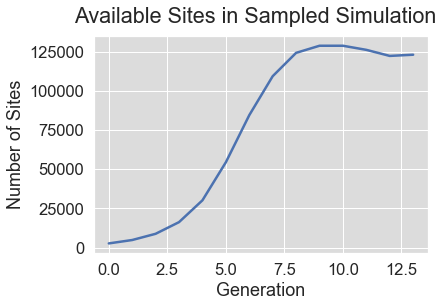

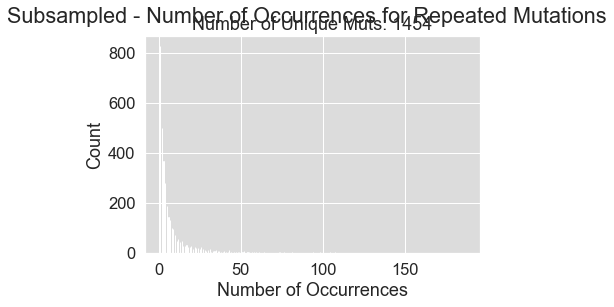

(10000, 30)
Time 1: 0.22133469581604004
Compute dictionary: 103.22899198532104
Conflict matrix is symmetric?  True
Total time: 104.04923486709595
Number of true recurrent muts:  3641
Number of detected recurrent muts:  4148
Number of true recurrent muts not detected: 0 with prevalence []


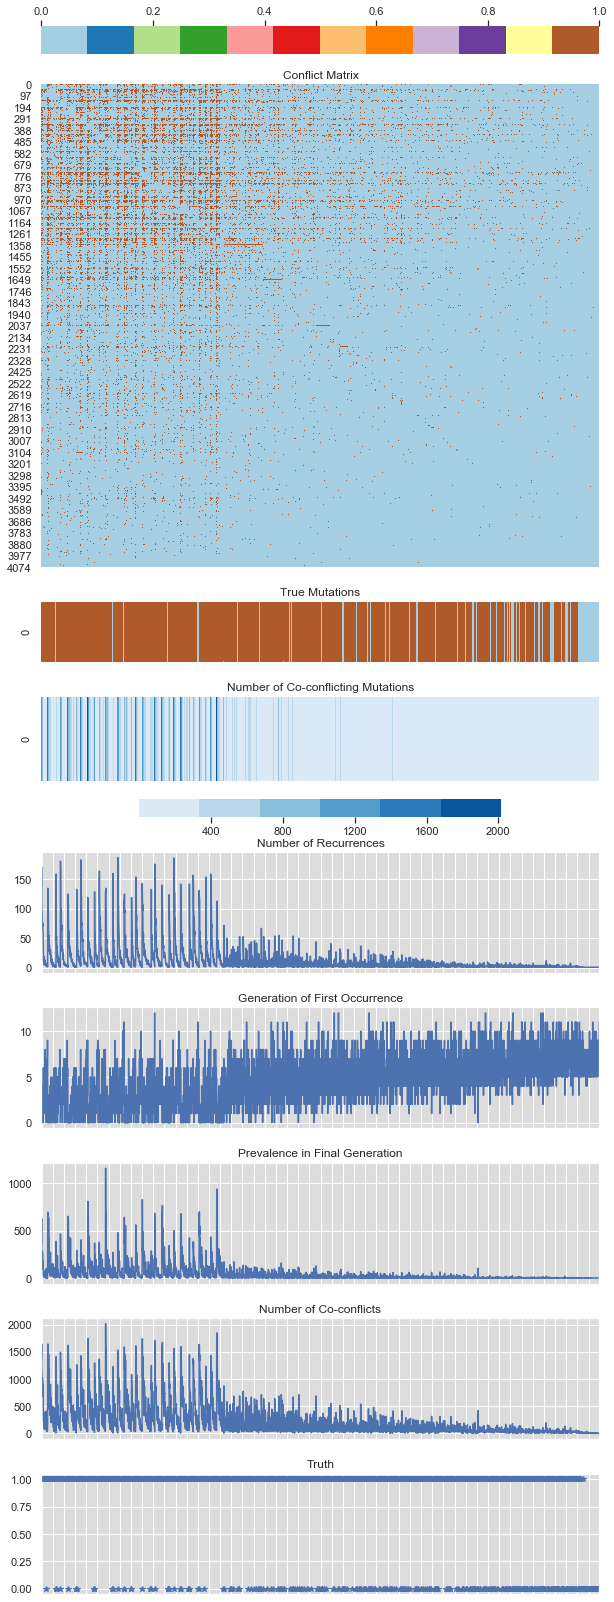

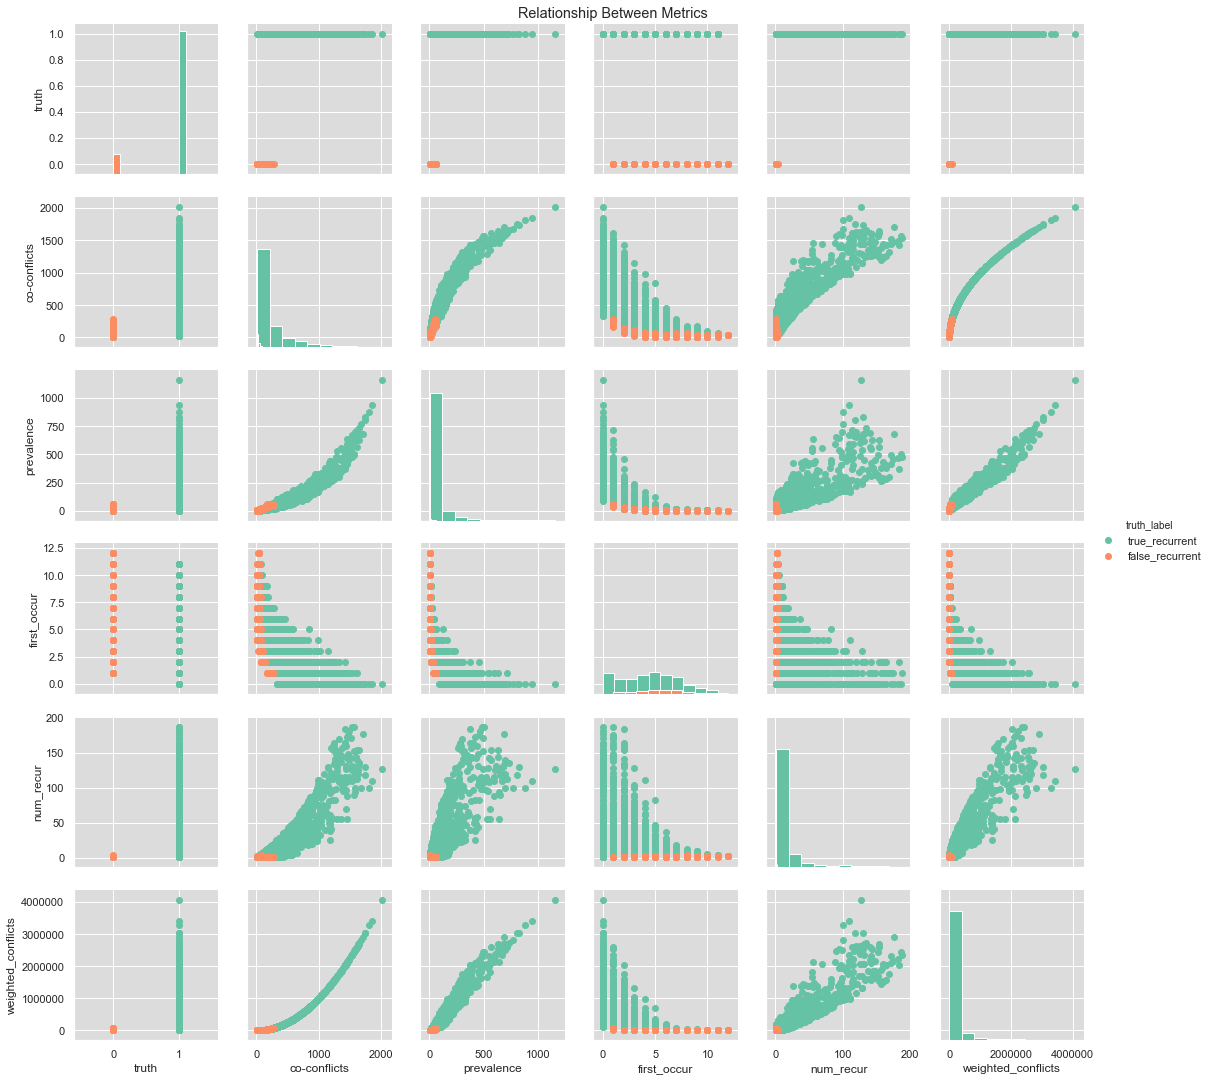

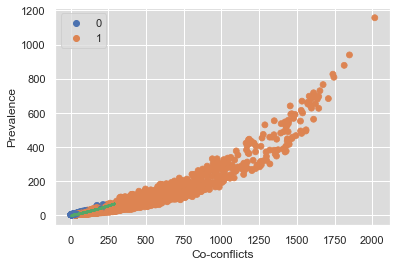

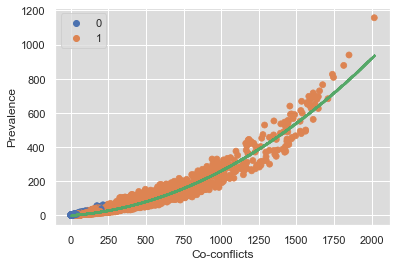

Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12


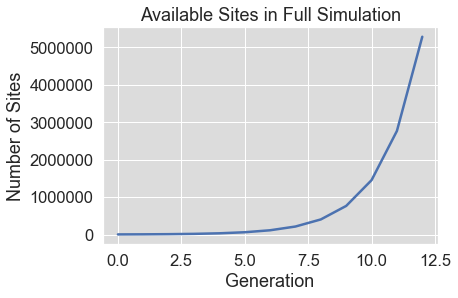

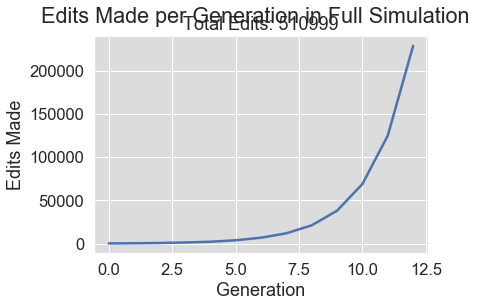

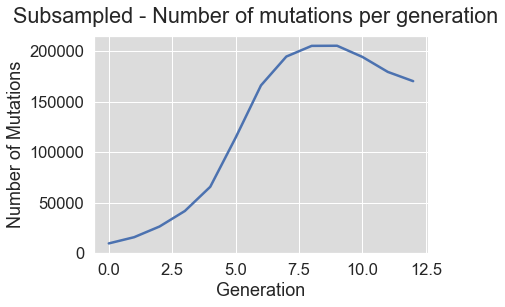

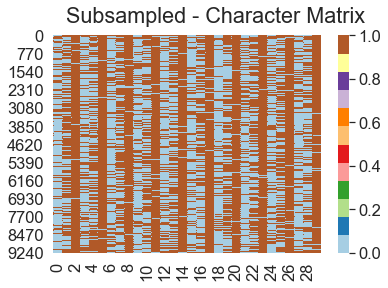

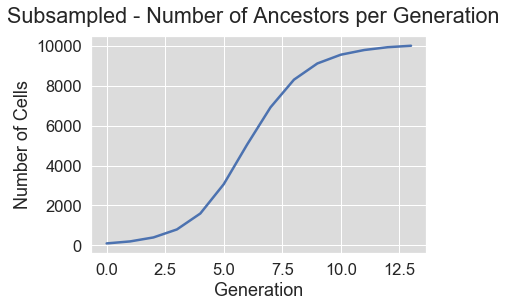

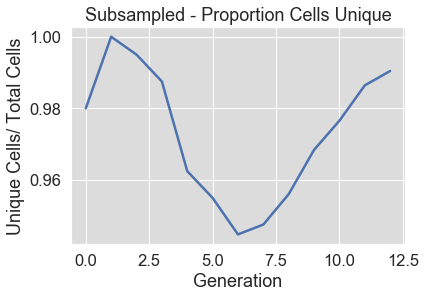

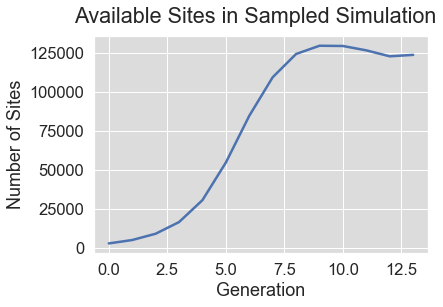

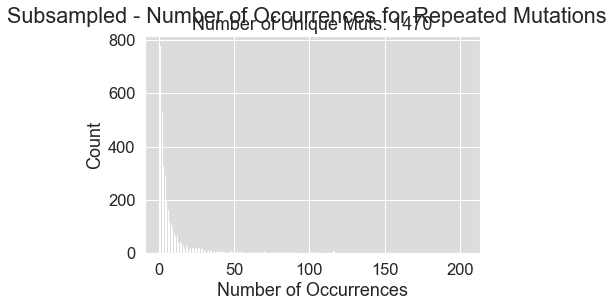

(10000, 30)
Time 1: 0.24054789543151855
Compute dictionary: 104.88266587257385
Conflict matrix is symmetric?  True
Total time: 105.71988773345947
Number of true recurrent muts:  3647
Number of detected recurrent muts:  4185
Number of true recurrent muts not detected: 0 with prevalence []


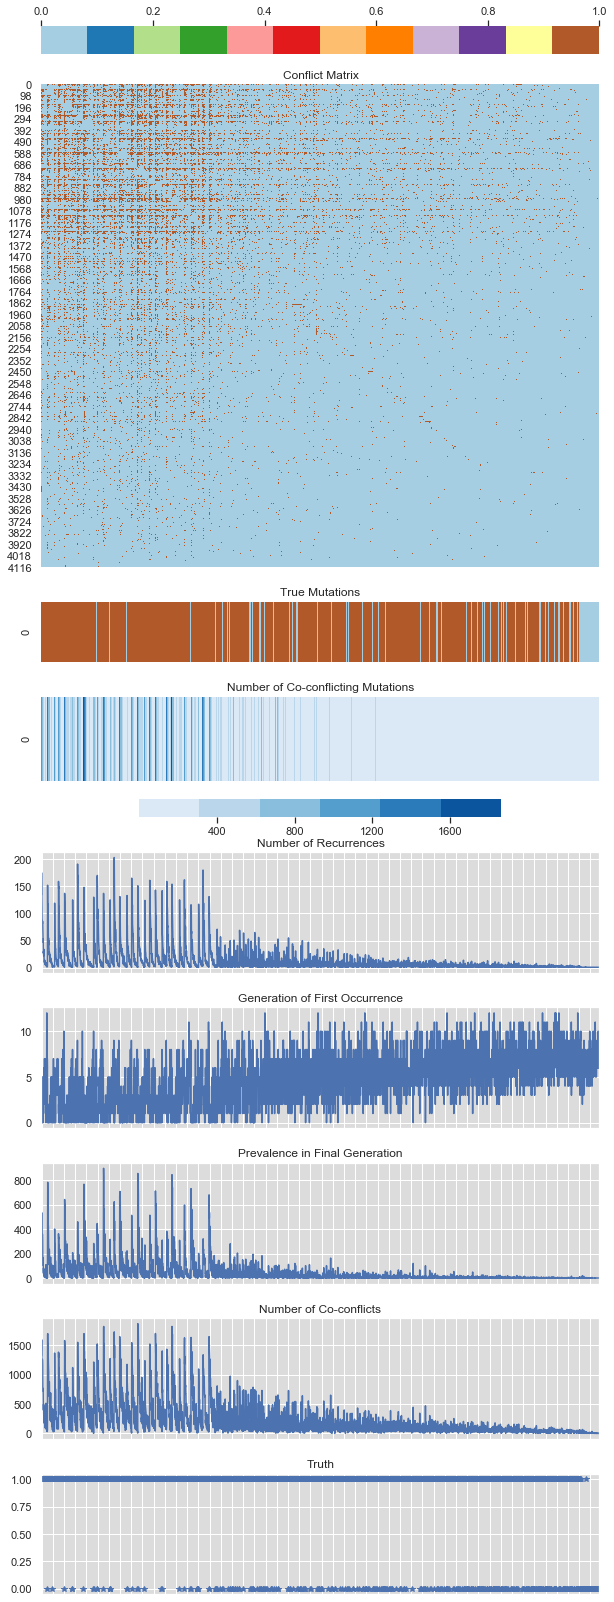

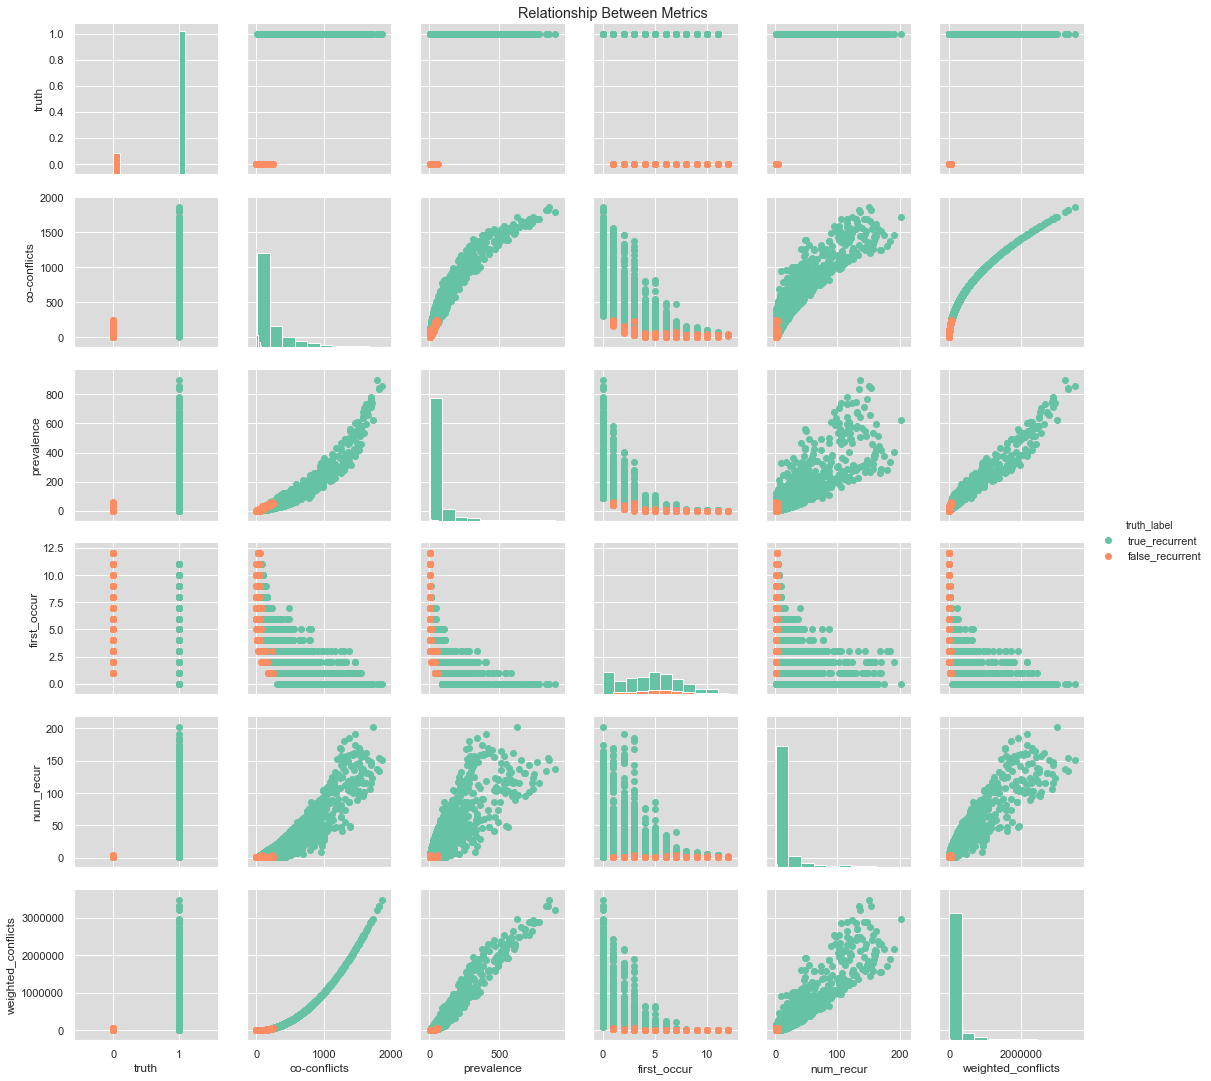

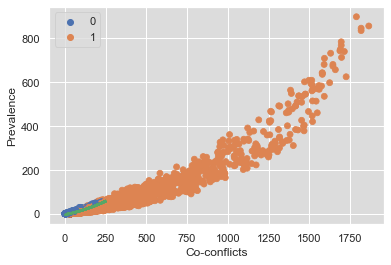

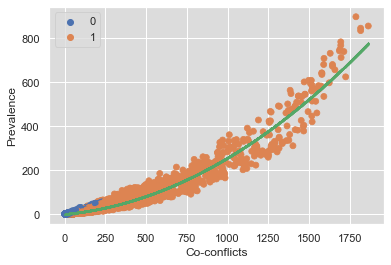

Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12


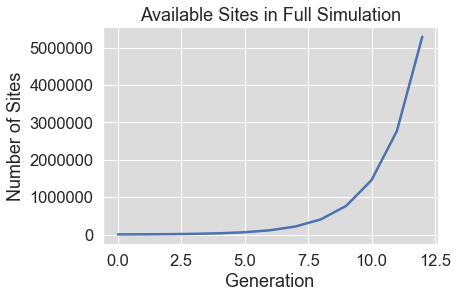

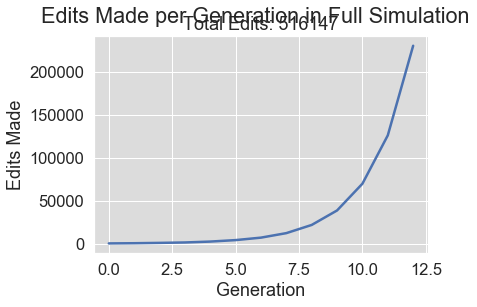

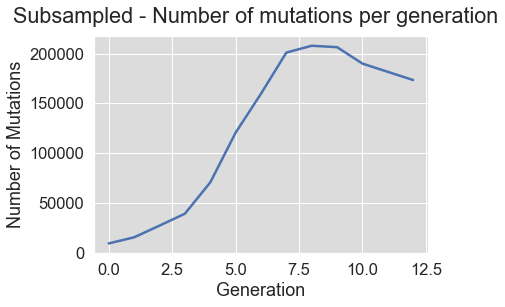

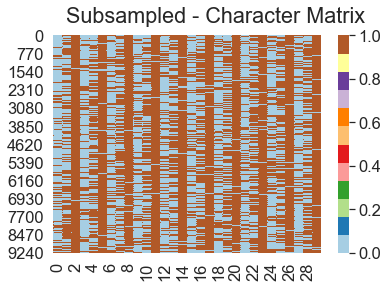

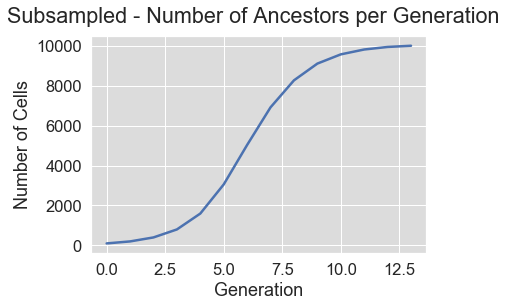

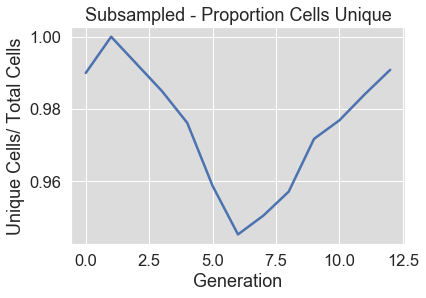

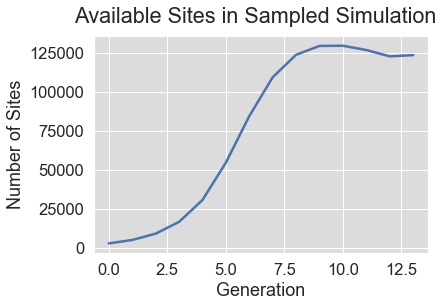

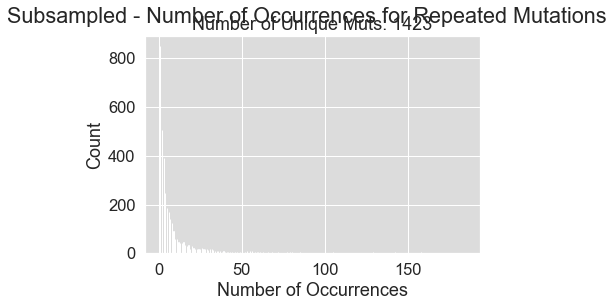

(10000, 30)
Time 1: 0.23849916458129883
Compute dictionary: 107.76805925369263
Conflict matrix is symmetric?  True
Total time: 108.62616300582886
Number of true recurrent muts:  3704
Number of detected recurrent muts:  4218
Number of true recurrent muts not detected: 0 with prevalence []


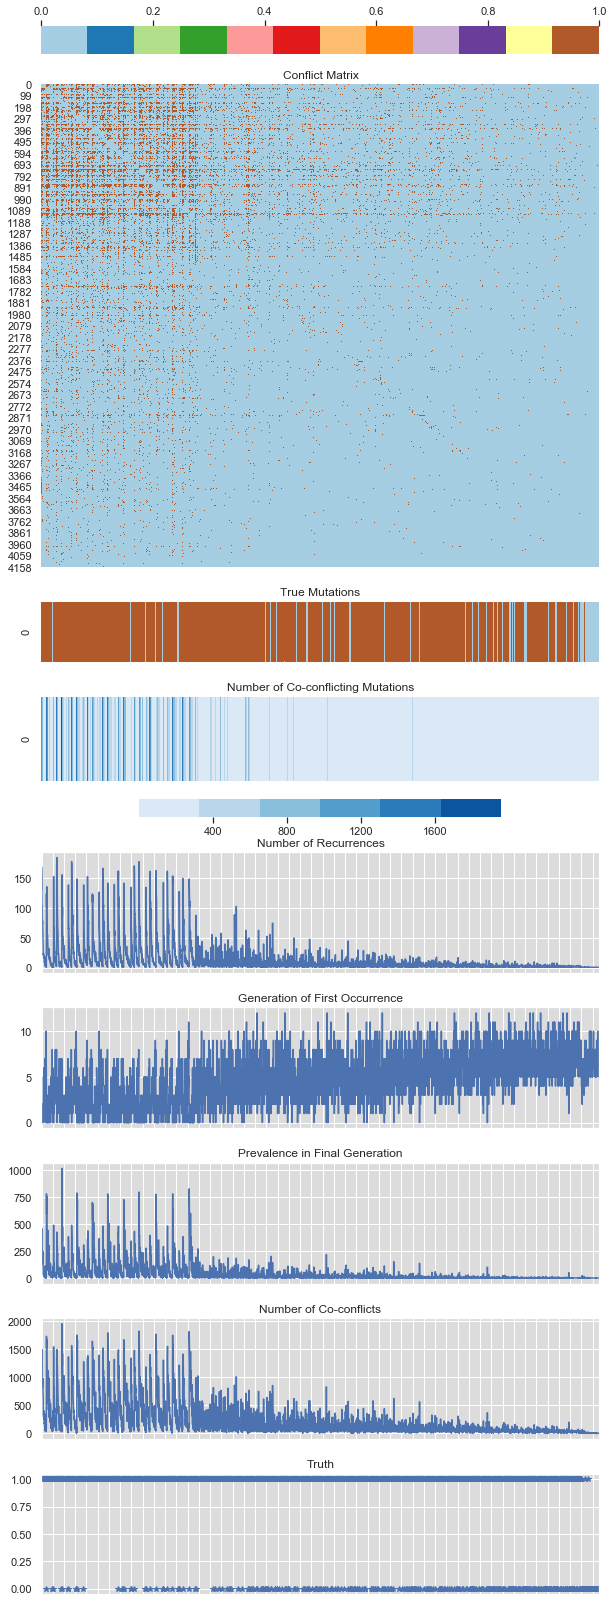

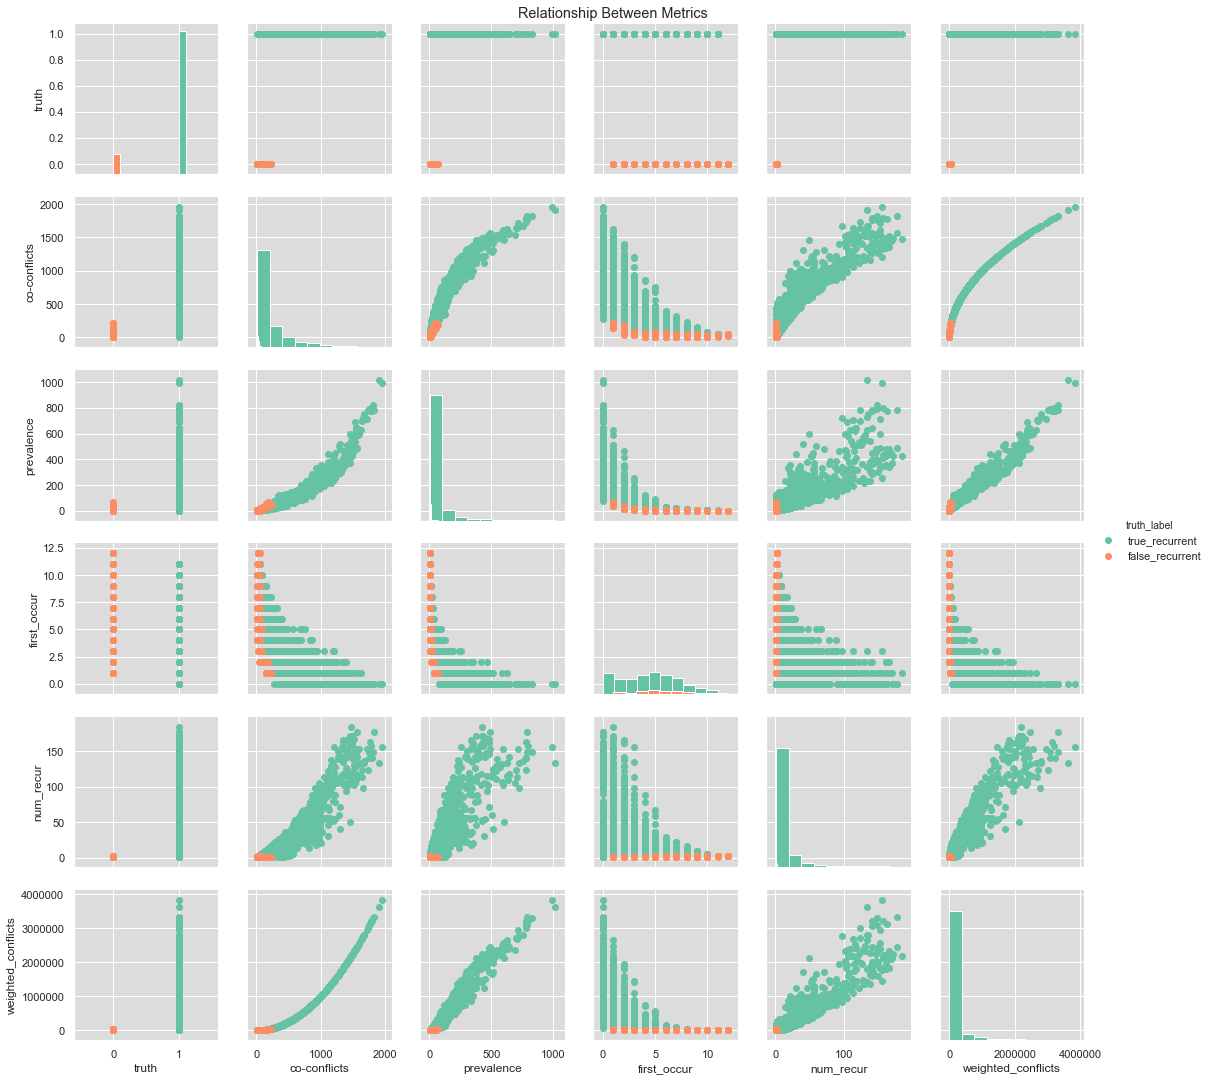

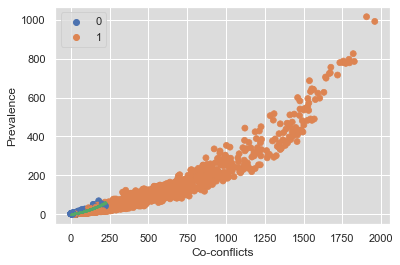

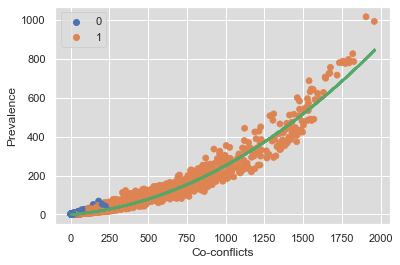

Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9


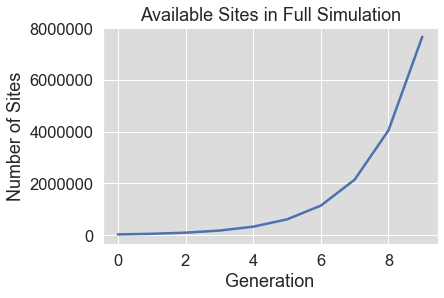

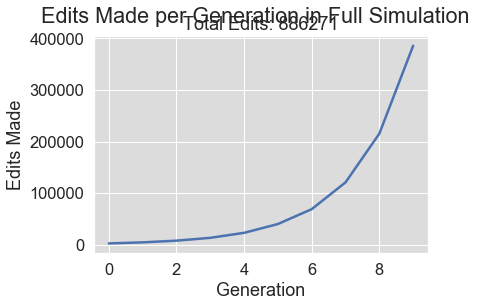

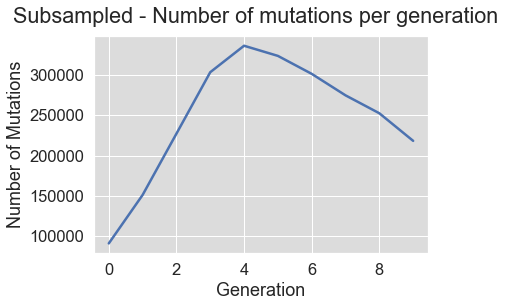

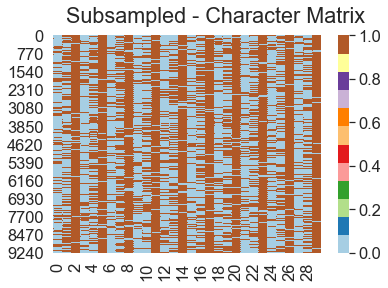

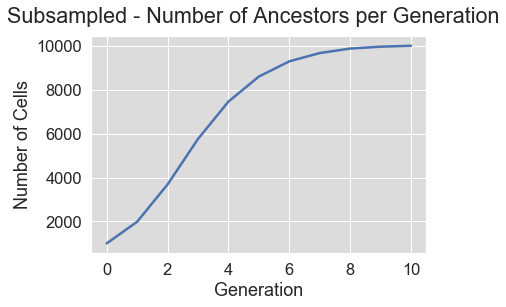

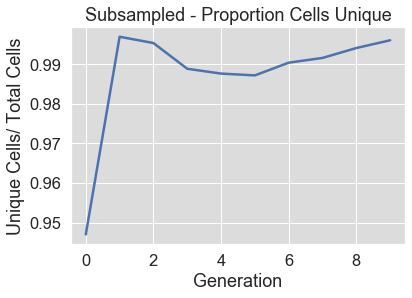

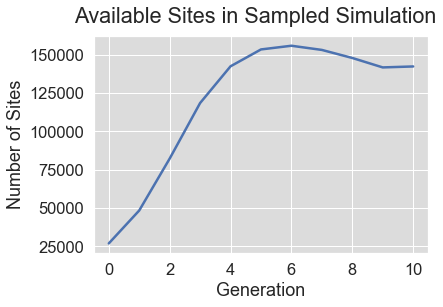

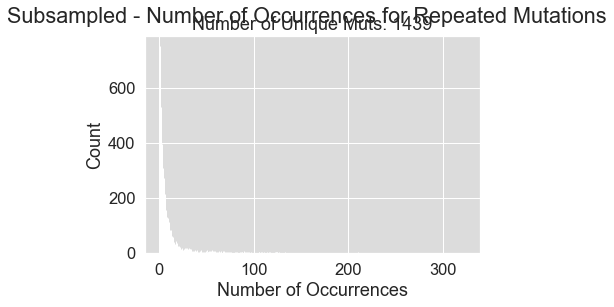

(10000, 30)
Time 1: 0.2523539066314697
Compute dictionary: 119.92148303985596
Conflict matrix is symmetric?  True
Total time: 120.86644506454468
Number of true recurrent muts:  4314
Number of detected recurrent muts:  4736
Number of true recurrent muts not detected: 0 with prevalence []


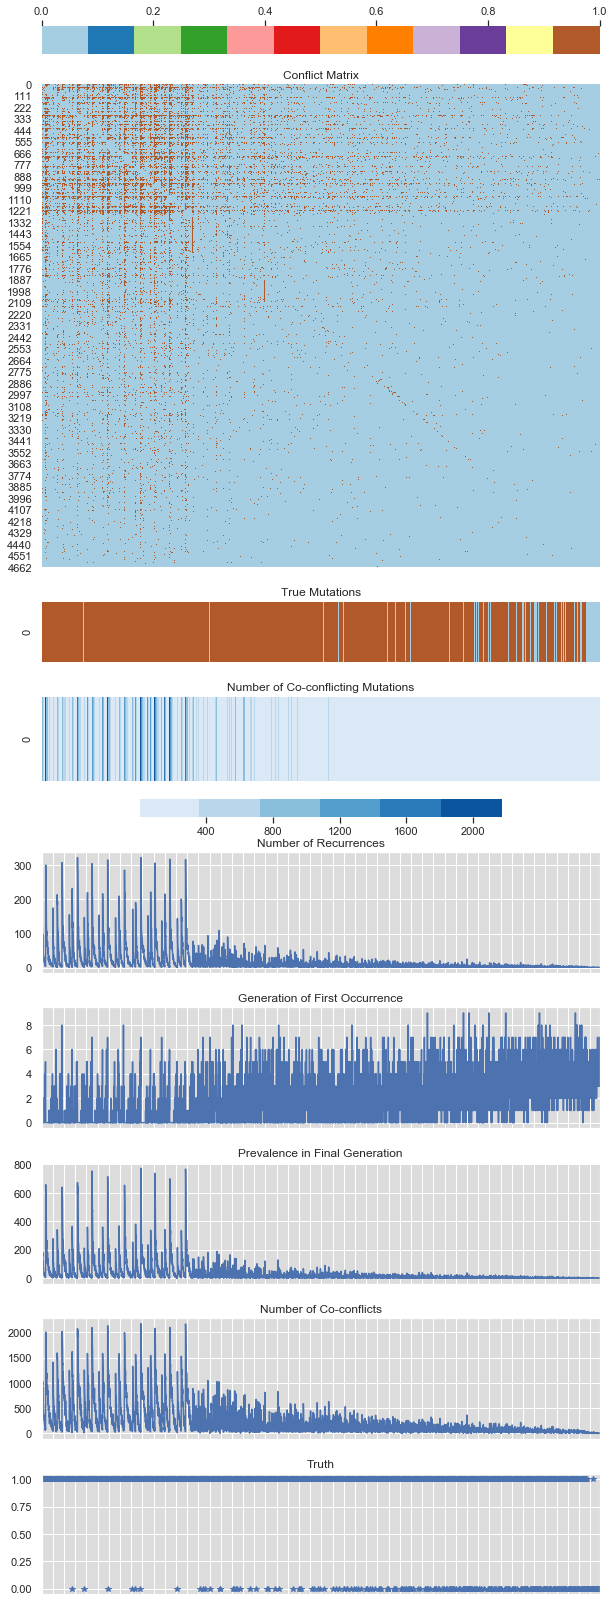

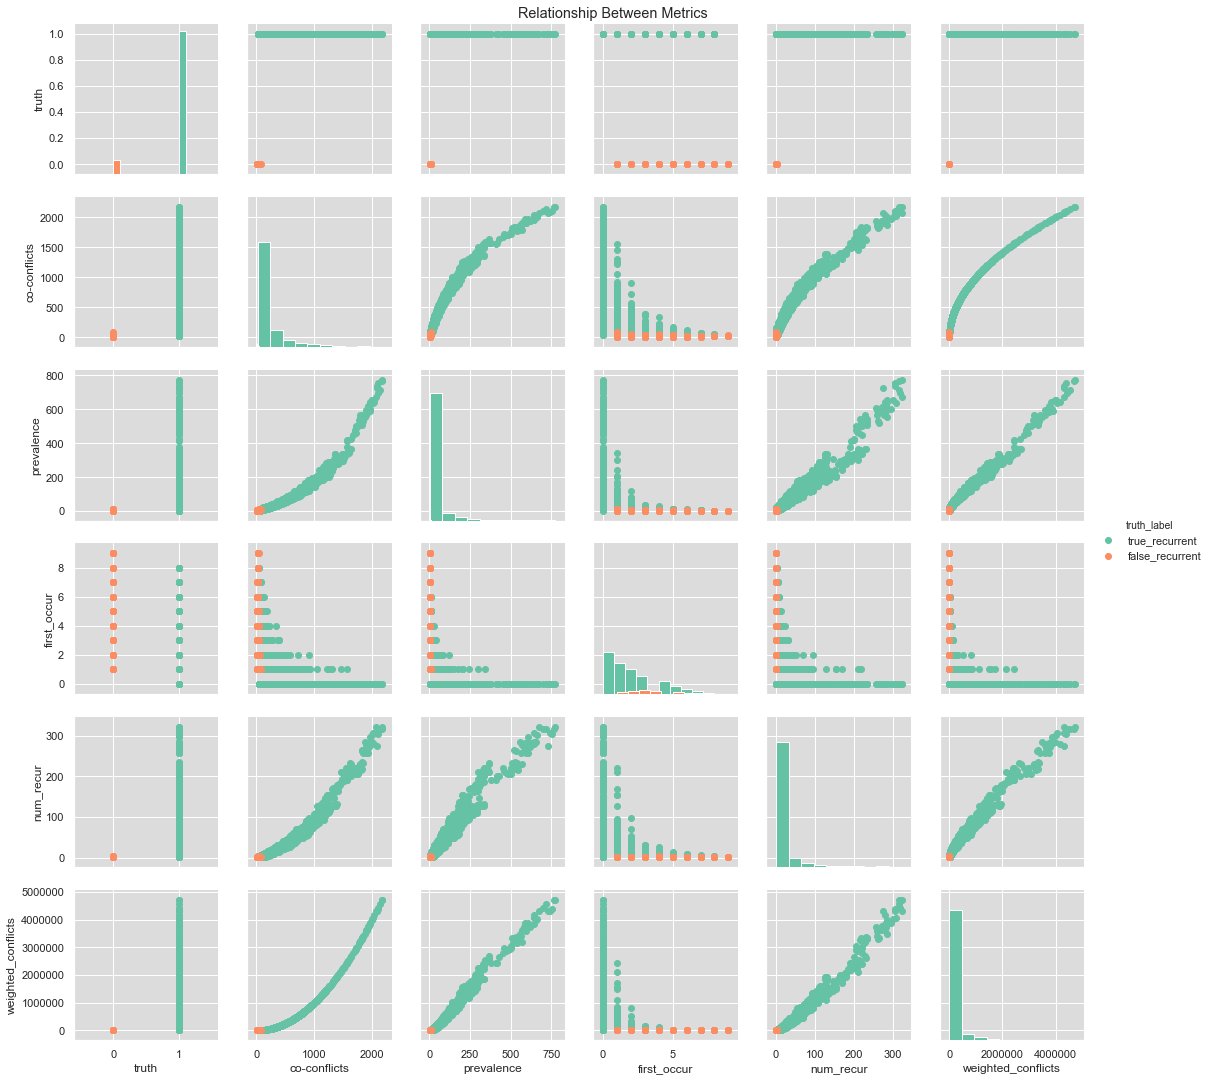

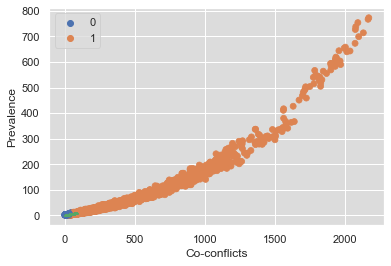

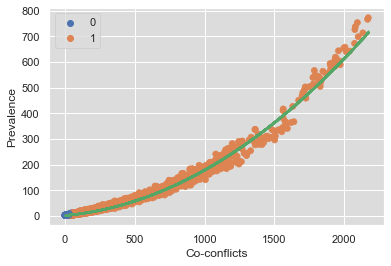

Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9


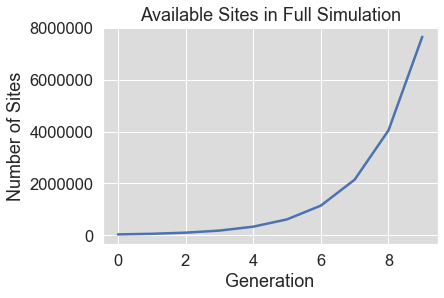

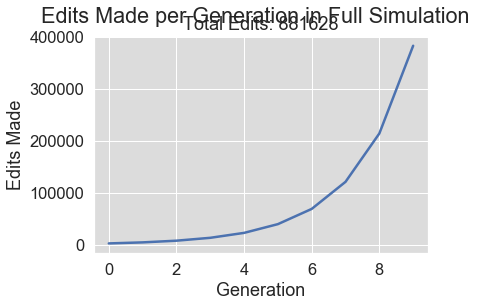

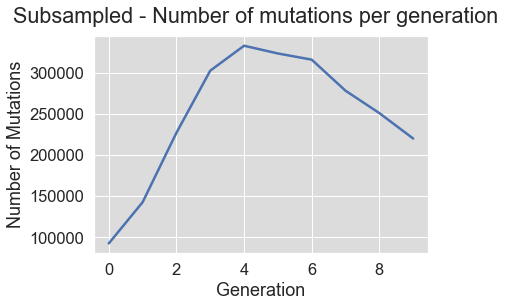

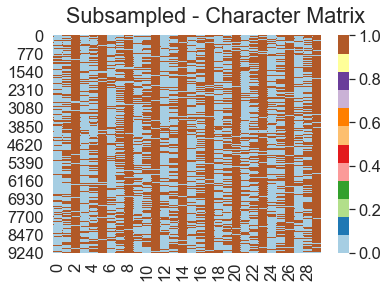

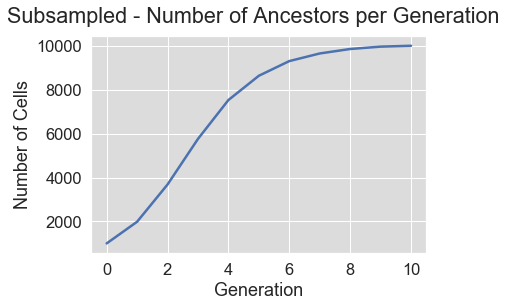

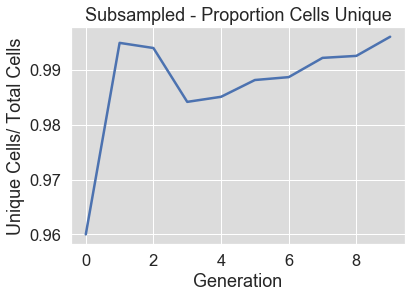

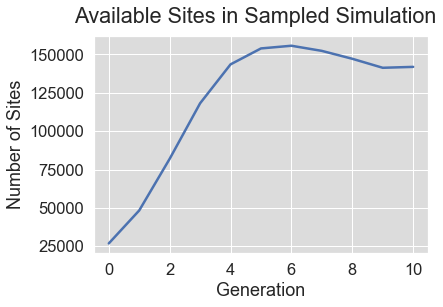

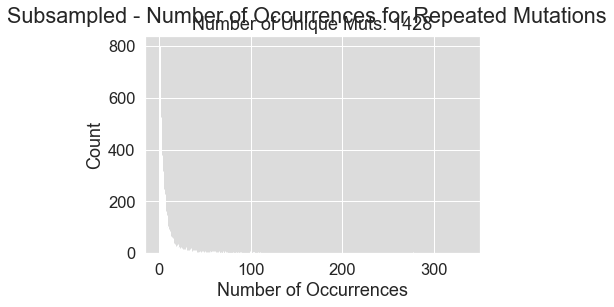

(10000, 30)
Time 1: 0.25106191635131836
Compute dictionary: 120.86338090896606
Conflict matrix is symmetric?  True
Total time: 121.89165592193604
Number of true recurrent muts:  4327
Number of detected recurrent muts:  4732
Number of true recurrent muts not detected: 0 with prevalence []


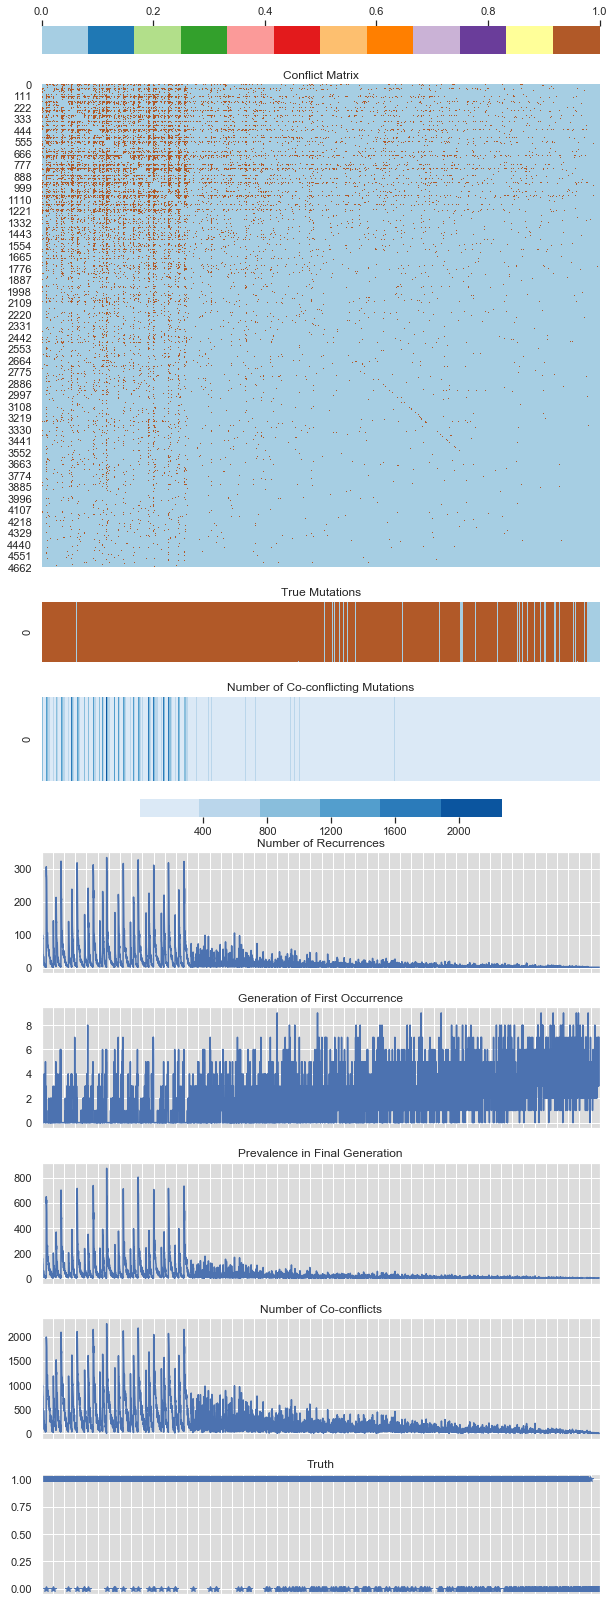

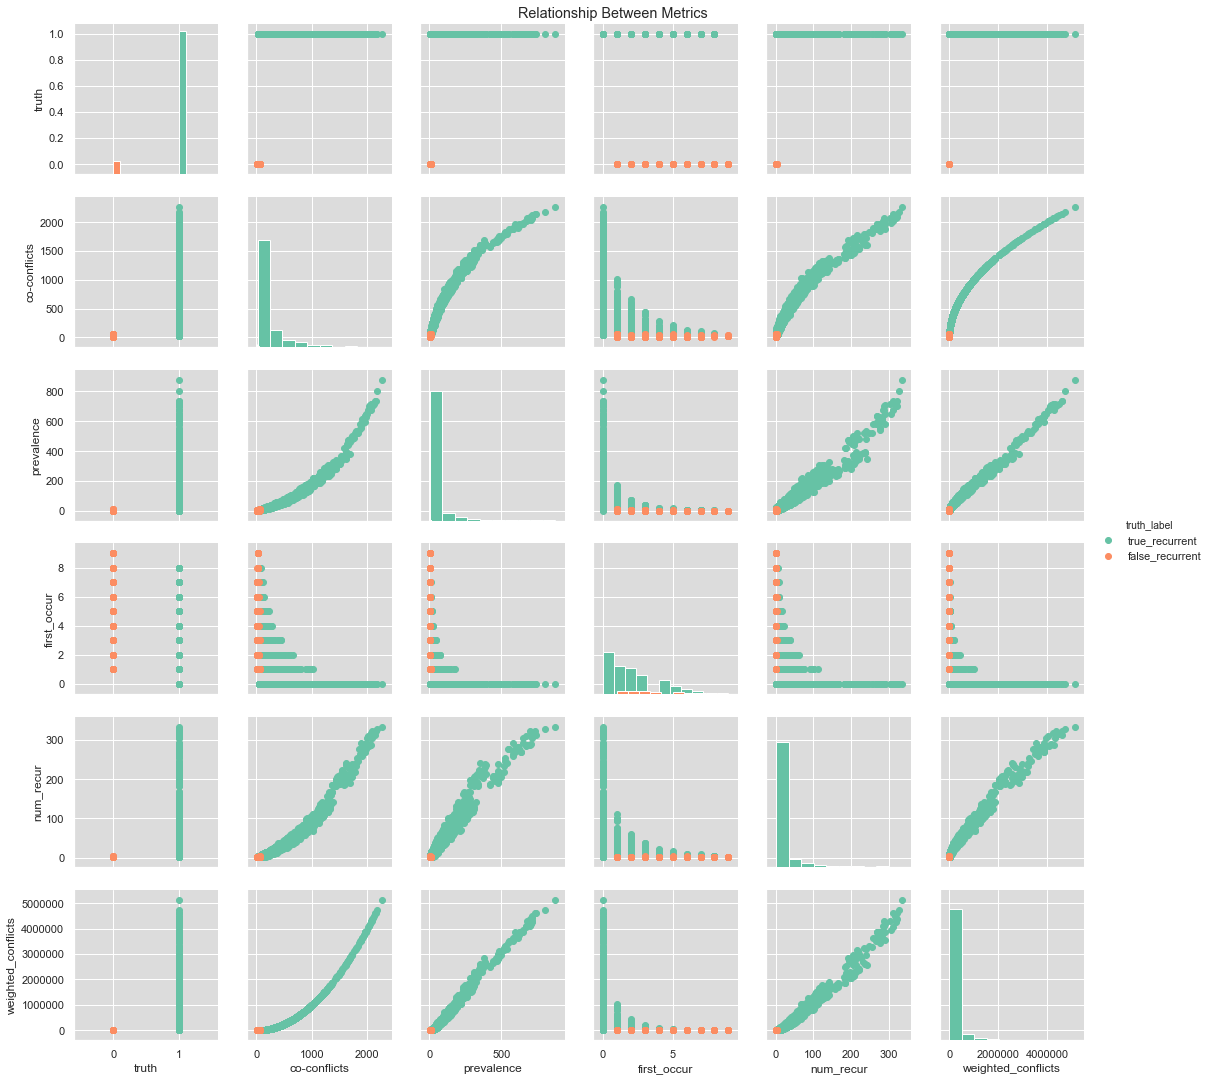

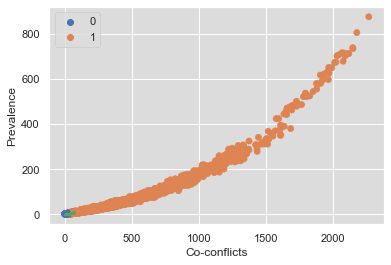

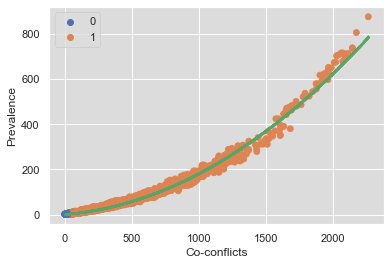

Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9


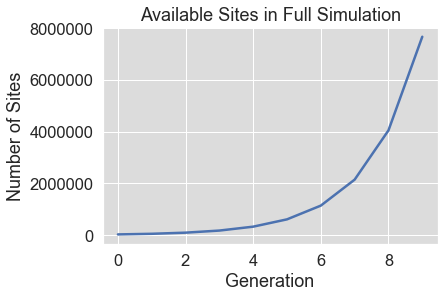

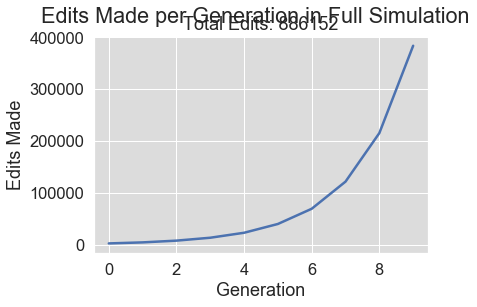

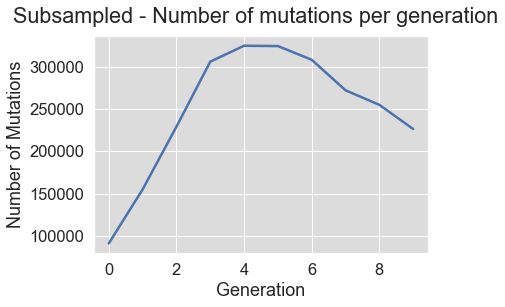

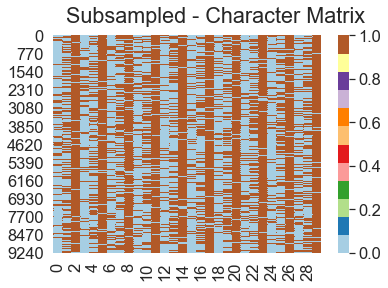

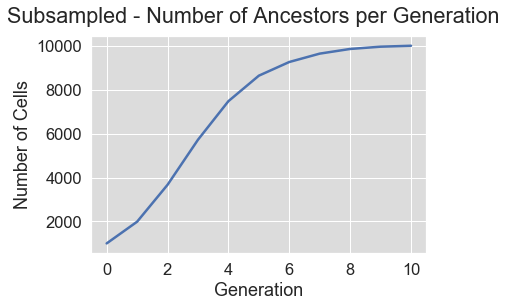

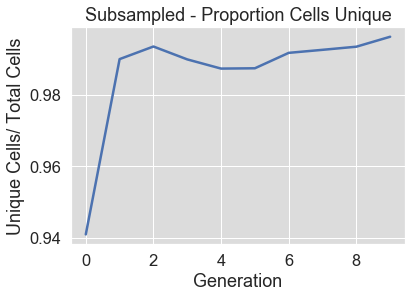

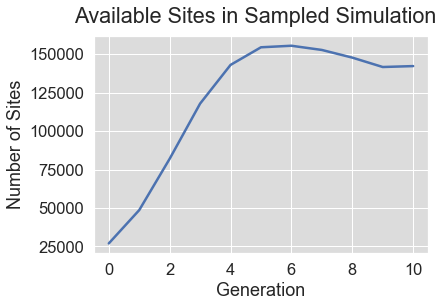

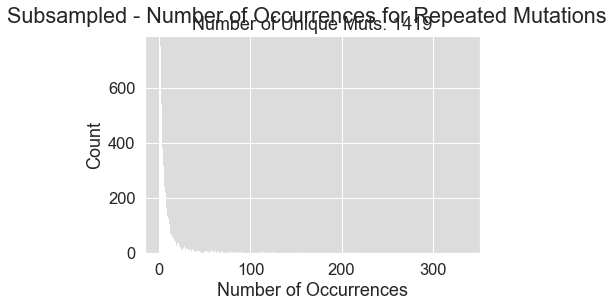

(10000, 30)
Time 1: 0.2689239978790283
Compute dictionary: 119.7471649646759
Conflict matrix is symmetric?  True
Total time: 120.80038785934448
Number of true recurrent muts:  4306
Number of detected recurrent muts:  4737
Number of true recurrent muts not detected: 0 with prevalence []


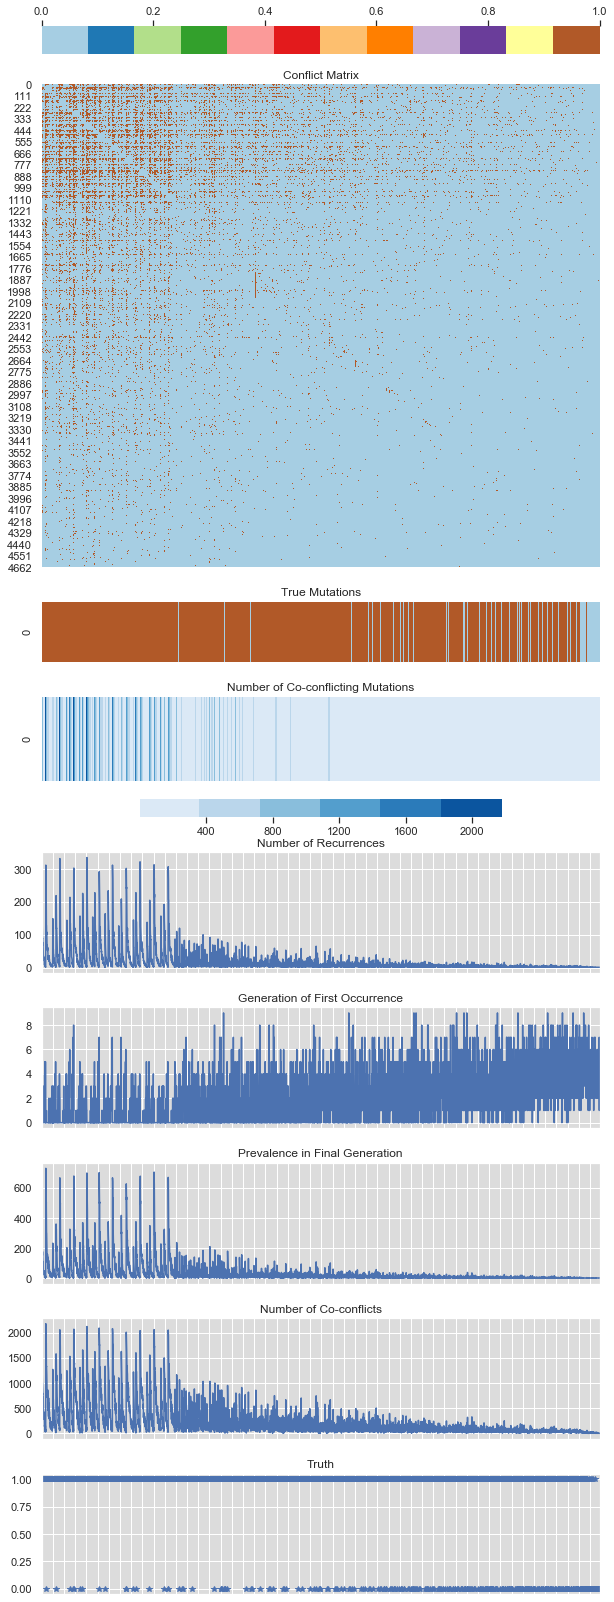

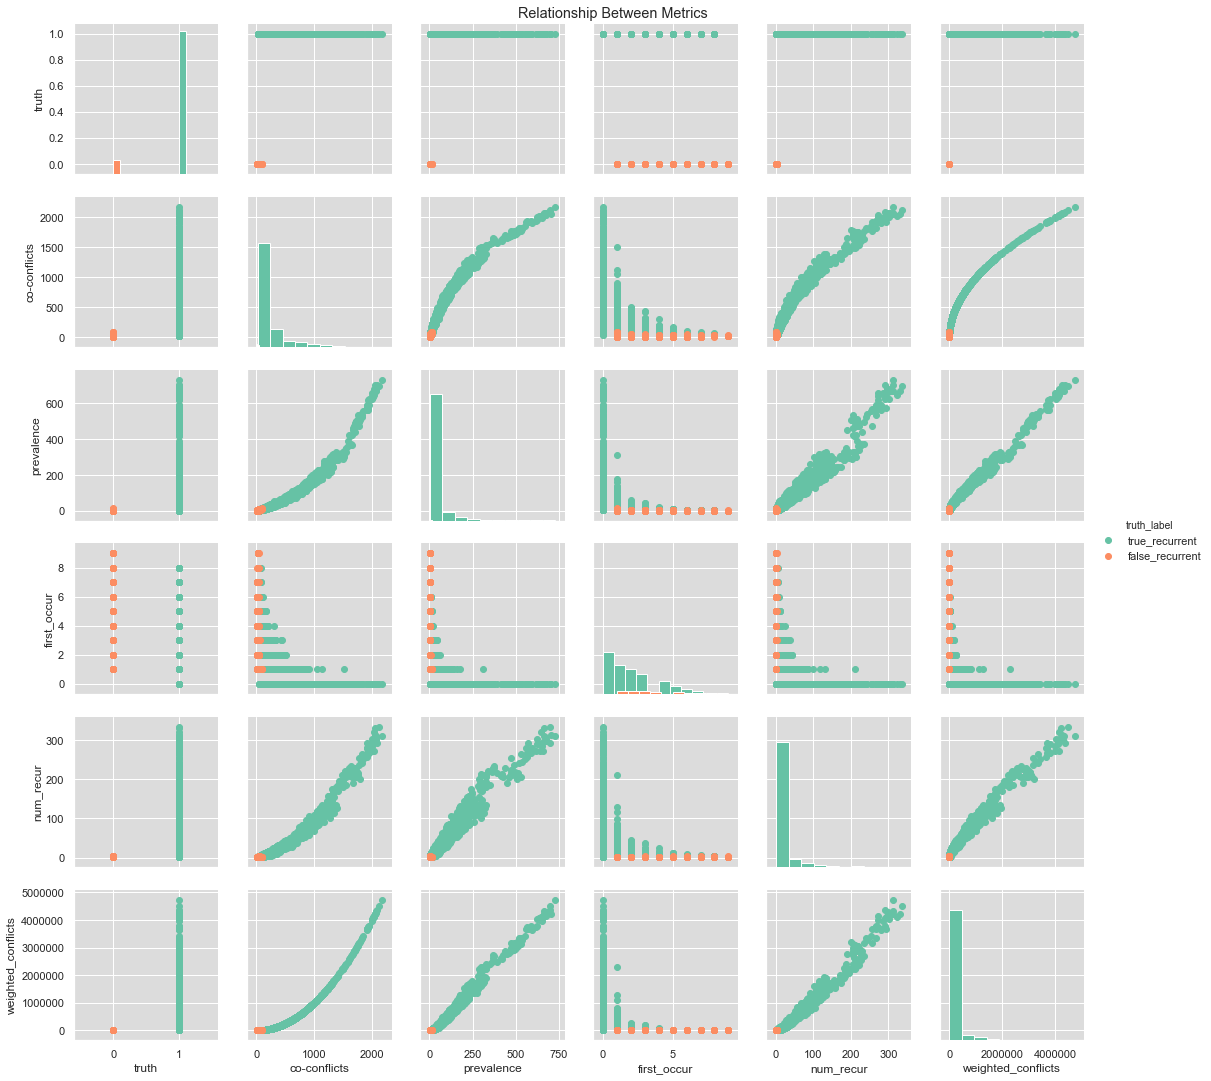

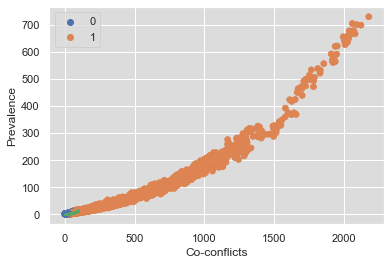

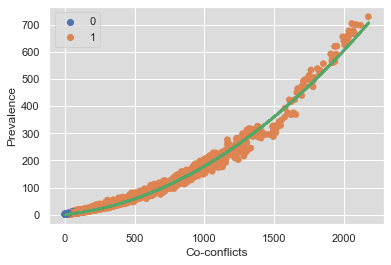

In [75]:
simulation_list = []
for i, list_of_guides in enumerate(lists_of_guides):
    label = labels[i]
    print('Label:', label)

    # Each array has 3-6 targets, we insert ~10 arrays. This gives us 30-60 sites
    site_ix = 0
    target_distributions = {}
    speed = {}
    for guide in list_of_guides:
        dist = indel_distributions[guide]
        try:
            del dist['']
        except KeyError:
            pass
        distvals = np.array(sorted(list(dist.values()), reverse=True))
        distvals = distvals/distvals.sum()
        target_distributions[site_ix] = distvals
        if guide in slow_guides:
            speed[site_ix] = 'slow'
        elif guide in medium_guides:
            speed[site_ix] = 'medium'
        else:
            speed[site_ix] = 'fast'

        site_ix += 1

    num_targets = site_ix 
    num_edit_sites = num_targets * num_arrays

    import itertools
    targets = list(itertools.product(np.arange(num_arrays), np.arange(num_targets)))
    print('List of targets: ', targets)

    deletions = []
    mutation_probs = []
    for array, target in targets:
        deletions.append(target_distributions[target])
        mutation_probs.append(rate[speed[target]])
    
    deletions_probs = pd.DataFrame(deletions)
    deletions_probs = torch.DoubleTensor(deletions_probs.fillna(0.0).values)
    
    # Each edit site has a different mutation probability 
    mutation_probs= np.array(mutation_probs)
    
    tree_depth_dict = {1:20, 10: 17, 100: 13, 1000: 10}
    for init_cells in [1, 10, 100, 1000]:
        tree_depth = tree_depth_dict[init_cells]
        for run in range(num_runs):
            simulation = lineageSimulation(label, tree_depth, num_edit_sites, deletions_probs, mutation_probs, init_cells=init_cells)

            try:
                # Summarize results
                # Plot a regression for the non-recurrent mutations
                X = simulation.conflict_matrix.sum(0)
                Y = simulation.prevalence_tape
                ix = np.array(simulation.truth_tape)==0

        #         from sklearn.linear_model import LinearRegression
        #         reg = LinearRegression().fit(X[ix].reshape(-1,1), Y[ix].reshape(-1,1))

                x = X[ix]
                y = Y[ix]

                new_x = np.linspace(min(x), max(x), num=np.size(x))
                coefs = np.polyfit(x,y,2)
                new_line = np.polyval(coefs, new_x)

                plt.figure()
                sns.scatterplot(X, Y, hue=simulation.truth_tape, 
                                cmap='Paired', edgecolor=None,)

                plt.scatter(new_x,new_line,c='g', marker='^', s=1)
                plt.xlabel('Co-conflicts')
                plt.ylabel('Prevalence')
                plt.show()
                plt.close()

                simulation.random_attr['coef'] = coefs


                simulation.random_attr['num_conflict'] = simulation.conflict_matrix.shape[0]

                x = X
                y = Y

                new_x = np.linspace(min(x), max(x), num=np.size(x))
                coefs = np.polyfit(x,y,2)
                new_line = np.polyval(coefs, new_x)

                plt.figure()
                sns.scatterplot(X, Y, hue=simulation.truth_tape, 
                                cmap='Paired', edgecolor=None,)

                plt.scatter(new_x,new_line,c='g', marker='^', s=1)
                plt.xlabel('Co-conflicts')
                plt.ylabel('Prevalence')
                plt.show()
                plt.close()

                simulation.random_attr['full_reg_coef'] = coefs

                simulation_list.append(simulation)
            except:
                print('Recurrent mutations not identified.')
        

In [80]:
[self.cell_record[0].shape[0]]*4

[1000, 1000, 1000, 1000]

In [84]:
tmp_df

label  full_open_site     gen  truth
0          1           356.0   684.0      1
1          1           148.0   431.0      1
2          1           150.0   416.0      1
3          1          2716.0  1536.0      1
4          1           163.0   396.0      1
...      ...             ...     ...    ...
46137   1000             2.0     5.0      0
46138   1000             2.0     2.0      0
46139   1000             2.0     1.0      0
46140   1000             2.0     3.0      0
46141   1000             2.0     2.0      0

[46142 rows x 4 columns]

1
1
1
10
10
10
100
100
100
1000
1000
1000


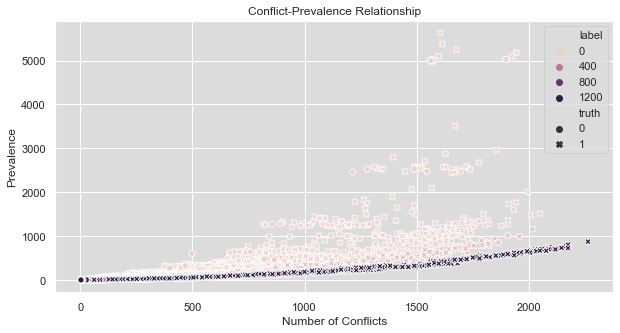

In [82]:
# Plot available sites in full simulation
plt.figure(figsize=(10,5))
tmp_df = {'label':[], 'full_open_site':[], 'gen':[], 'truth':[]}
for self in simulation_list:
    t = self.prevalence_tape
    n_gens = len(t)
    print(self.cell_record[0].shape[0])
    tmp_df['label'] += [self.cell_record[0].shape[0]]*n_gens
    tmp_df['truth'] += list(self.truth_tape)
    tmp_df['full_open_site'] += list(t)
    tmp_df['gen'] += list(self.conflict_matrix.sum(0))
    
tmp_df = pd.DataFrame(tmp_df)
sns.scatterplot(x="gen", y="full_open_site", hue='label', style='truth', data=tmp_df)
plt.title('Conflict-Prevalence Relationship')
plt.xlabel('Number of Conflicts')
plt.ylabel('Prevalence')
plt.legend()
plt.show()
plt.close()

<Figure size 720x720 with 0 Axes>

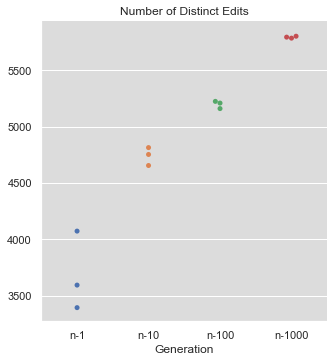

In [123]:
# Plot available sites in full simulation
plt.figure(figsize=(10,10))
tmp_df = {'label':[], 'full_open_site':[]}
for self in simulation_list:
    t = [self.get_feature_matrix().shape[1]]
    tmp_df['label'] += ['n-'+str(self.cell_record[0].shape[0])]
    tmp_df['full_open_site'] += list(t)
    
tmp_df = pd.DataFrame(tmp_df)
sns.catplot(x='label', y="full_open_site", kind='swarm',data=tmp_df)
plt.title('Number of Distinct Edits')
plt.xlabel('Generation')
plt.ylabel('')
plt.show()
plt.close()

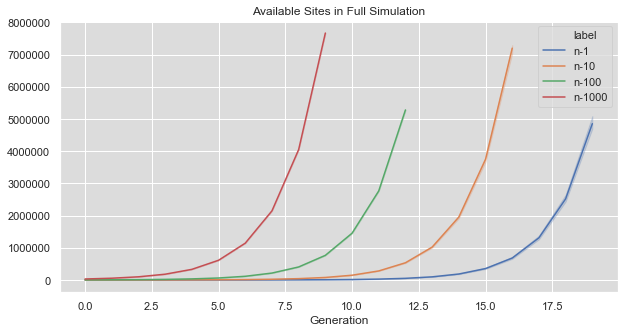

In [117]:
# Plot available sites in full simulation
plt.figure(figsize=(10,5))
tmp_df = {'label':[], 'full_open_site':[], 'gen':[]}
for self in simulation_list:
    t = self.full_open_sites
    n_gens = len(t)
    tmp_df['label'] += ['n-'+str(self.cell_record[0].shape[0])]*n_gens
    
    tmp_df['full_open_site'] += list(t)
    tmp_df['gen'] += list(np.arange(n_gens))
    
tmp_df = pd.DataFrame(tmp_df)
sns.lineplot(x="gen", y="full_open_site", hue='label',data=tmp_df)
plt.title('Available Sites in Full Simulation')
plt.xlabel('Generation')
plt.ylabel('')
plt.legend()
plt.show()
plt.close()

In [141]:
from ipywidgets import *
import plotly.graph_objs as go

import numpy as np

x = np.random.rand(100)
y = np.random.rand(100)

f = go.FigureWidget([go.Scatter(x=x, y=y, mode='markers')])

scatter = f.data[0]
colors = ['#a3a7e4'] * 100
scatter.marker.color = colors
scatter.marker.size = [10] * 100
f.layout.hovermode = 'closest'


# create our callback function
def update_point(trace, points, selector):
    c = list(scatter.marker.color)
    s = list(scatter.marker.size)
    for i in points.point_inds:
        c[i] = '#bae2be'
        s[i] = 20
        scatter.marker.color = c
        scatter.marker.size = s


scatter.on_click(update_point)


<IPython.core.display.Javascript object>


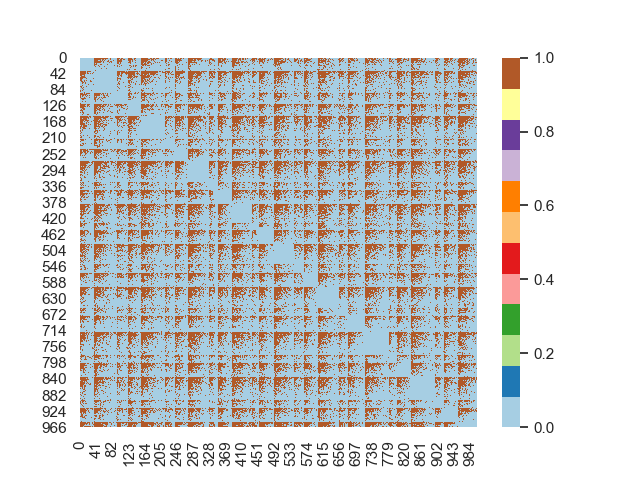

In [238]:
%matplotlib notebook

sns.heatmap(conflict_matrix, cmap='Paired')
plt.show()

In [245]:
np.where(conflict_matrix[60]==1)[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 73, 74, 75, 76,
       77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
       94, 95, 97, 98, 99])

In [241]:
conflict_matrix = self.conflict_matrix[:N, :N]
prevalence = self.prevalence_tape[:N]

print(conflict_matrix.tolist())

prevalence

[[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1

array([3.560e+02, 1.480e+02, 1.500e+02, 2.716e+03, 1.630e+02, 7.400e+01,
       1.010e+02, 9.800e+01, 1.390e+02, 1.120e+02, 5.500e+01, 1.344e+03,
       4.000e+01, 1.272e+03, 3.300e+01, 8.000e+00, 6.000e+00, 7.000e+00,
       7.000e+01, 4.700e+01, 2.000e+01, 3.700e+01, 4.600e+01, 4.000e+00,
       4.840e+02, 1.210e+02, 5.100e+01, 5.800e+01, 4.600e+01, 5.100e+01,
       4.400e+01, 2.400e+01, 4.400e+01, 5.700e+01, 2.000e+01, 2.500e+01,
       7.000e+01, 6.840e+02, 4.200e+01, 2.400e+01, 5.000e+00, 2.300e+01,
       2.200e+01, 9.700e+01, 1.700e+01, 1.290e+03, 5.800e+01, 7.000e+00,
       2.900e+01, 8.000e+00, 4.100e+01, 2.700e+01, 1.420e+03, 8.300e+01,
       7.000e+01, 3.400e+01, 7.900e+01, 2.800e+01, 1.600e+01, 5.700e+01,
       5.099e+03, 1.243e+03, 8.000e+00, 9.000e+00, 2.800e+01, 6.000e+00,
       2.100e+01, 1.360e+02, 3.000e+00, 6.000e+00, 7.000e+00, 2.500e+01,
       5.000e+00, 3.160e+02, 1.770e+02, 9.300e+01, 7.700e+01, 1.630e+02,
       3.390e+02, 1.590e+02, 1.080e+02, 2.400e+01, 

In [273]:
truth_tape

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [284]:
truth_tape==0

False

In [290]:
color = np.array(['mediumaquamarine']*len(prevalence))
color[np.array(truth_tape)==0]= 'orange'

array([[0.4       , 0.80392157, 0.66666667, 1.        ],
       [0.4       , 0.80392157, 0.66666667, 1.        ],
       [0.4       , 0.80392157, 0.66666667, 1.        ],
       ...,
       [1.        , 0.64705882, 0.        , 1.        ],
       [1.        , 0.64705882, 0.        , 1.        ],
       [0.4       , 0.80392157, 0.66666667, 1.        ]])

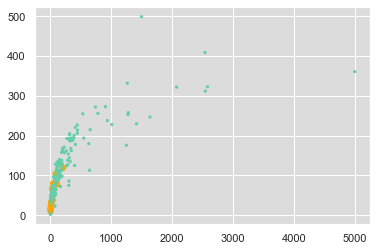

In [289]:

%matplotlib inline 
fig, ax = plt.subplots()
coll = ax.scatter(prevalence, conflict_matrix.sum(0), color=color, picker = 5, s=list((1-np.array(truth_tape))*20+5))
plt.show()

smf 1


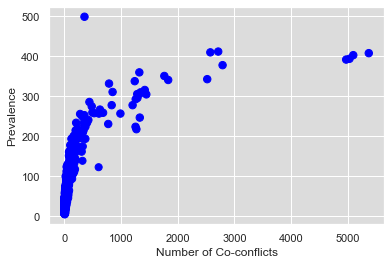

smf 1


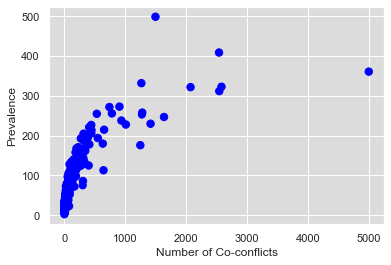

In [291]:
self = simulation_list[0]
N = 500 

conflict_matrix = self.conflict_matrix[:N, :N]

prevalence = self.prevalence_tape[:N]
truth_tape = self.truth_tape[:N]

def plot_co_conflicts(prevalence, conflict_matrix, truth_tape):
   
    fig, ax = plt.subplots()
    coll = ax.scatter(prevalence, conflict_matrix.sum(0), color=["blue"]*len(prevalence), picker = 5, s=list(np.array(truth_tape)*5+50))
    plt.grid(True)

    def on_pick(event):
        original_color = [1.        , 0.64705882, 0.        , 1.        ]
        for i in event.ind:
            linked = np.where(conflict_matrix[i]==1)[0]
            if np.all(coll._edgecolors[i,:] == original_color):
                change_to = (1,0,0,1)
            else:
                change_to = original_color
            coll._facecolors[linked,:] = change_to
            coll._edgecolors[linked,:] = change_to
            coll._facecolors[i,:] = change_to
            coll._edgecolors[i,:] = change_to

        fig.canvas.draw()
    plt.xlabel('Number of Co-conflicts')
    plt.ylabel('Prevalence')
    fig.canvas.mpl_connect('pick_event', on_pick)
    plt.show()
    
for self in simulation_list[:2]:
    print(self.label, self.cell_record[0].shape[0])
    conflict_matrix = self.conflict_matrix[:N, :N]

    prevalence = self.prevalence_tape[:N]
    plot_co_conflicts(prevalence, conflict_matrix, self.truth_tape)

<IPython.core.display.Javascript object>


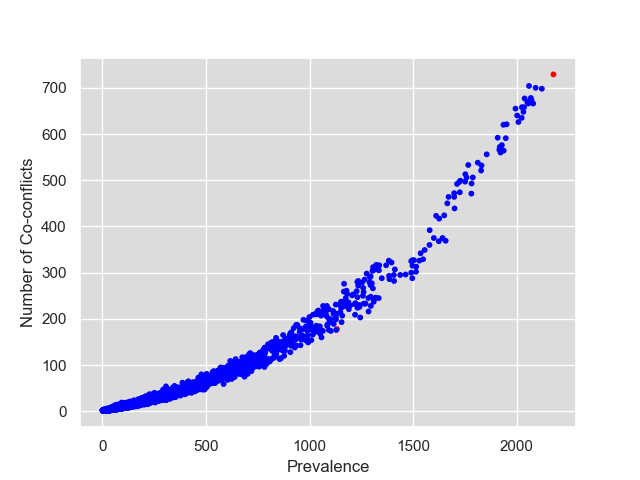

In [228]:
%matplotlib notebook

import matplotlib.pyplot as plt

# testData = np.array([[0,0], [0.1, 0], [0, 0.3], [-0.4, 0], [0, -0.5]])
testData = self.prevalence_tape
fig, ax = plt.subplots()
coll = ax.scatter(self.conflict_matrix.sum(0), self.prevalence_tape, color=["blue"]*len(testData), picker = 1, s=[10]*len(testData))
plt.grid(True)

def on_pick(event):
    original_color = (0,0,1,1)
    linked = np.where(self.conflict_matrix[event.ind]==1)[0]
    if np.all(coll._facecolors[event.ind,:] == original_color):
    	change_to = (1,0,0,1)
    else:
    	change_to = original_color
    coll._facecolors[linked,:] = change_to
    coll._edgecolors[linked,:] = change_to
    coll._facecolors[event.ind,:] = change_to
    coll._edgecolors[event.ind,:] = change_to

    fig.canvas.draw()
plt.ylabel('Number of Co-conflicts')
plt.xlabel('Prevalence')
fig.canvas.mpl_connect('pick_event', on_pick)
plt.show()

fig.canvas.mpl_connect('pick_event', on_pick)
plt.show()

In [180]:
import plotly.graph_objs as go
from ipywidgets import Output, VBox

fig = go.FigureWidget()
fig.add_pie(values=[1, 2, 3])
pie = fig.data[0]

out = Output()
@out.capture(clear_output=True)
def handle_click(trace, points, state):
    print(points.point_inds)

pie.on_click(handle_click)

VBox([fig, out])

from IPython.display import display 
display(VBox([fig, out]))

    'data': [{'type': 'pie', 'uid': '094e241c-e1f9-4fba-ab46-0b6ae8986930', 'val…

## Naive Tree Distance Reconstruction

In [8]:
from triplets_correct import triplets_correct

In [9]:
for simulation in simulation_list:
    trees, n_correct = triplets_correct(simulation, inferred_trees= ['nj', 'upgma'])
    print(n_correct, 'Correct')


Got feature matrix
257.2984049320221
distance matrix 1.2692501544952393
tree build 29849.22271990776
[2455 5699 1489]
[7670 6917 6081]
[2467 7795  121]
[ 464 8455 2869]
[4112 6877 5984]
[  74 4162 3938]
[6379 6019 4080]
[5764 3926 5261]
[8767 3098 8137]
[4349 5767 8723]
{'nj': 0.5, 'upgma': 0} Correct
Got feature matrix
205.121426820755
distance matrix 1.2625181674957275


KeyboardInterrupt: 

## Evaluating the Effectiveness of Dropping Recurrent Mutations 

### Removal by Fitted Prevalence-Conflict Curve

In [ ]:
for enum, simulation in enumerate(simulation_list[:-1]):
    
    X = simulation.get_conflict_matrix().sum(0)
    Y = simulation.get_prevalance_tape()
    ix = np.array(simulation.get_truth_tape())==0

    coefs = simulation.random_attr['full_reg_coef']
    new_line = np.polyval(coefs, X)
    
    std_dev = np.std(np.abs(Y-new_line))
    bad_muts = Y < new_line + 0.5*std_dev
    
    # Constrain these to only those within the main 10-90 percent 
    q10, q90 = np.percentile(X, [75, 99])

    middleX = (X > q10)*(X < q90) 
    bad_muts = bad_muts * middleX
    
    if enum < 10:
        plt.figure(figsize=(15,15))
        sns.scatterplot(X, Y, hue=bad_muts, size=np.array(simulation.truth_tape))
        new_x = np.linspace(min(X), max(X), num=np.size(X))
        new_line = np.polyval(coefs, new_x)
        plt.scatter(new_x, new_line, c='g', marker='^', s=0.2)
        plt.xlabel('Number of Conflicts')
        plt.ylabel('Prevalence')
        plt.show()
        plt.close()
    
    # How many identified as bad muts are bad muts?
    
    bad_identified = np.array(simulation.truth_tape)[bad_muts]
    print('Percent truly identified as bad:', 100*bad_identified.sum()/bad_identified.shape[0])
    print('Proportion of total eliminated: ', 100*bad_identified.shape[0]/X.shape[0])
    
    ## What does the conflict matrix look like after removing these?
    
    # Get the indices of those mutations identified as recurrent
    bad_ix = np.sort(np.where(bad_muts)[0])[::-1]
    
    conflict_matrix = simulation.get_conflict_matrix()
    truth = simulation.get_truth_tape()
    first_gen_tape = copy.deepcopy(simulation.first_gen_tape)
    
    print(first_gen_tape)
    prevalence_tape = simulation.get_prevalance_tape()
    conflicts = conflict_matrix.sum(0)
    removed_truth = []
    
    for max_ix in bad_ix:
        conflict_matrix = np.delete(conflict_matrix, max_ix, axis=0)
        conflict_matrix = np.delete(conflict_matrix, max_ix, axis=1)

        # What mutation does this index map to?
        removed_truth.append(truth.pop(max_ix))


        first_gen_tape = np.delete(first_gen_tape, max_ix, axis=0)
        prevalence_tape = np.delete(prevalence_tape, max_ix, axis=0)
        conflicts = np.delete(conflicts, max_ix, axis=0)

    # How has removing this mutation affected the number of conflicts for true vs false recurrent mutations 
    new_conflicts = conflict_matrix.sum(0)

    delta = conflicts - new_conflicts

    df = {'truth_label': ['true_recurrent' if i else 'false_recurrent' for i in truth ],  
           'co-conflicts_new':new_conflicts,'delta':delta, 'prevalence': prevalence_tape}
    df = pd.DataFrame(df)

    df['product'] = df['prevalence']*df['co-conflicts_new']
    df['weighted_conflcits'] = (conflict_matrix*conflict_matrix.sum(0)).sum(0)
    df['gen_occurred'] = first_gen_tape
    pd.melt(df)

    if enum < 10:
        # Plot the prevalence vs co-conflicts after removing this set
        X = conflict_matrix.sum(0)
        Y = prevalence_tape
        
        plt.figure(figsize=(15,15))
        sns.scatterplot(X, Y, size=np.array(truth))
        plt.ylabel('Prevalence')
        plt.xlabel('Number of Conflicts')
        plt.show()
        plt.close()
                
        for sq in range(1,4):
            X = conflict_matrix.sum(0)
            weighted_X = (conflict_matrix*conflict_matrix.sum(0)**sq).sum(0)

            plt.figure(figsize=(15,15))
            sns.scatterplot(weighted_X, Y, size=np.array(truth))
            plt.ylabel('Prevalence')
            plt.xlabel('Weighted Conflicts power {0}'.format(sq))
            plt.show()
            plt.close()

        g = sns.PairGrid(df, hue = 'truth_label', palette="Set2")
        g.map_diag(plt.hist)
        g.map_offdiag(plt.scatter)
        g.add_legend()
        g.fig.suptitle("Change in Parameters after Removing Most Conflicting Mut", y=1) # y= some height>1
        plt.show()
        plt.close()


    

In [ ]:
## Which mutations are the misidentified mutations conflicting with?

# Weight mutations by whether they have many co-conflicts. 
for simulation in simulation_list[:-1]:
    X = simulation.get_conflict_matrix()
    X_sum = X.sum(0)
    
    weighted_X = (X * X_sum).sum(0)
    Y = simulation.get_prevalance_tape()
    
    plt.figure(figsize=(15,15))
    sns.scatterplot(weighted_X, Y, hue=np.array(simulation.truth_tape))
    plt.xlabel('Weighted Number of Conflicts')
    plt.ylabel('Prevalence')
    plt.show()
    plt.close()

### Iterative Removal Process

In [ ]:
def iterative_removal(conflict_matrix, truth, prevalence_tape, first_gen_tape, num_recur_tape, all_conflicting):
    conflict_matrix = copy.deepcopy(conflict_matrix)
    truth = copy.deepcopy(truth)
    prevalence_tape = copy.deepcopy(prevalence_tape)
    first_gen_tape = copy.deepcopy(first_gen_tape)
    num_recur_tape = copy.deepcopy(num_recur_tape)
    mutations = copy.deepcopy(all_conflicting)
    
    removed = []
    removed_truth = []
    eliminated_truth = []
    first_good_mut = []
    first_good_mut_by_product = []
    
    total_muts = conflict_matrix.shape[0]
    print('Starting with {0} candidate recurrent mutations'.format(conflict_matrix.shape[0]))
    while conflict_matrix.shape[0] > 0:
        conflicts = conflict_matrix.sum(0)

        # How long until we remove a good mutation 
        sortIx = conflicts.argsort()[::-1]
        first_good_mut.append(np.where(np.array(truth)[sortIx]==0)[0][0])

        product = conflicts*prevalence_tape
        sortIx = product.argsort()[::-1]
        first_good_mut_by_product.append(np.where(np.array(truth)[sortIx]==0)[0][0])

        # Remove the mutation with the maximum number of conflicts
        conflicts = conflict_matrix.sum(0)
        max_ix = np.argmax(conflicts)
        conflict_matrix = np.delete(conflict_matrix, max_ix, axis=0)
        conflict_matrix = np.delete(conflict_matrix, max_ix, axis=1)
        # What mutation does this index map to?
        removed.append(mutations.pop(max_ix))
        removed_truth.append(truth.pop(max_ix))

#         if not removed_truth[-1]:
#             print('Removed a not-recurrent mutation!')

        first_gen_tape = np.delete(first_gen_tape, max_ix, axis=0)
        prevalence_tape = np.delete(prevalence_tape, max_ix, axis=0)
        num_recur_tape = np.delete(num_recur_tape, max_ix, axis=0)
        conflicts = np.delete(conflicts, max_ix, axis=0)

        # How has removing this mutation affected the number of conflicts for true vs false recurrent mutations 
        new_conflicts = conflict_matrix.sum(0)

        delta = conflicts - new_conflicts

        df = {'truth_label': ['true_recurrent' if i else 'false_recurrent' for i in truth ],  
               'co-conflicts_new':new_conflicts,'delta':delta, 'prevalence': prevalence_tape} #, 'first_occur': first_gen_tape, 'num_recur': num_recur_tape}
        df = pd.DataFrame(df)

        df['product'] = df['prevalence']*df['co-conflicts_new']
        df['div'] = df['co-conflicts_new']/df['prevalence']
        pd.melt(df)
        
        if len(removed) < 10:
            g = sns.PairGrid(df, hue = 'truth_label', palette="Set2")
            g.map_diag(plt.hist)
            g.map_offdiag(plt.scatter)
            g.add_legend()
            g.fig.suptitle("Change in Parameters after Removing Most Conflicting Mut", y=1) # y= some height>1
            plt.show()
            plt.close()

            df['co-conflicts_new'].hist(by=df['truth_label'])
            plt.suptitle('Number of Co-occuring Mutations after Removing {0} Mutations'.format(len(removed)))
            plt.xlabel('Number of Co-conflicts')
            plt.ylabel('Number of Mutations')
            plt.show()
            plt.close()

        # Remove rows, columns in conflict matrix with no conflicts
        no_conflict = np.where(conflict_matrix.sum(0)==0)[0][::-1] 
        #Reverse this so we can delete elements without messing up order

        for max_ix in no_conflict:
            conflict_matrix = np.delete(conflict_matrix, max_ix, axis=0)
            conflict_matrix = np.delete(conflict_matrix, max_ix, axis=1)

            eliminated_truth.append(truth.pop(max_ix))
            mutations.pop(max_ix)
            
#             if eliminated_truth[-1]:
#                 print('Eliminated a recurrent mutation!')

            first_gen_tape = np.delete(first_gen_tape, max_ix, axis=0)
            prevalence_tape = np.delete(prevalence_tape, max_ix, axis=0)
            num_recur_tape = np.delete(num_recur_tape, max_ix, axis=0)
            conflicts = np.delete(conflicts, max_ix, axis=0)

    plt.figure()
    plt.title('Removed_truth')
    plt.plot(np.arange(len(removed_truth)), removed_truth)
    plt.show()
    plt.close()
    
    plt.figure()
    plt.title('Eliminated_truth: {0:2f}%'.format(100*len(eliminated_truth)/total_muts ))
    plt.plot(np.arange(len(eliminated_truth)), eliminated_truth)
    plt.show()
    plt.close()
    
    return removed

In [ ]:
removed = iterative_removal(conflict_matrix, truth, prevalence_tape, first_gen_tape, num_recur_tape, all_conflicting)

In [ ]:
# Build

### Actually nan-out recurrent mutations

In [ ]:
final_cells_clean = copy.deepcopy(pd.DataFrame(subsampled_record[-1]))
for (col, edit) in removed:
    ix = (final_cells_clean[col]==edit)
    # Remove this edit (no need to use it again)
    final_cells_clean.loc[ix, col] = np.nan
    
final_cells_clean.head(2)

### Construct greedy tree using cleaned mutations

In [ ]:
final_cells_clean['Label'] = '1'
final_cells_clean_labeled = split_tree(final_cells_clean)

In [ ]:
final_cells_clean_labeled

### Compute triplets correct

In [ ]:

trees, n_correct = triplets_correct(simulation, inferred_trees= ['nj', 'upgma'], n_samples=1000)


#### Remove all TRUE recurrent mutations and see what happens

In [ ]:
f = simulation.get_feature_matrix()

In [ ]:
simulation.final_cells

In [ ]:
true_tree = simulation.true_tree

In [ ]:
true_tree

## Computing expected recurrences

## Things to do:

1. Debug triplets correct metric 
2. Figure out why neighbor joining is crashing 
3. Try Camin-Sokal 
4. When we eliminate recurrent mutations, what is the generation/ how many cells is it present in? (prevalence)?

In [ ]:
import scipy
data = scipy.spatial.distance.pdist(final_cells.values, metric='hamming')

In [ ]:
from skbio import DistanceMatrix
from skbio.tree import nj

dm = DistanceMatrix(data)



In [ ]:
def prob_no_muts(subtree_height, p_edit, p_mut, memo_table):
    """
    For a given target site and mutation character, compute the probability that a subtree of given height
    contains no instances of that mutation.
    
    p[d] = p_edit * (1-p_mut) + (1-p_edit)*p[d+1]^2 
    leaf case: p[d+1] = 1
    """
    if subtree_height in memo_table:
        return memo_table[subtree_height], memo_table
    
    if subtree_height == 0:
        ans = p_edit*(1-p_mut) + (1-p_edit)
    else: 
        ans, memo_table = prob_no_muts(subtree_height - 1, p_edit, p_mut, memo_table)
        ans = p_edit*(1-p_mut) + (1-p_edit)*(ans**2)  
    
    memo_table[subtree_height] = ans 
    return ans, memo_table

MAX_HEIGHT = 10
d = 5
p_edit = 0.02
p_mut = 1/250

# Compute the overall probability of a specific mutation at depth d (estimated from the prevalence prev) :

## FOR A GIVEN SITE AND A GIVEN MUTATION 

# Compute the probability that the specific mutation occurs in NONE of the offshoot trees:
memo_table ={}
running_prob = 1
for height in range(0, d):
    ans, memo_table = prob_no_muts(MAX_HEIGHT - height, p_edit, p_mut, memo_table)
    # We also need to multiply this by the probability that this site was not occupied in any of its ancestors
    running_prob *= ans*(1-p_edit)**height

# Compute the probability that this mutation occurs in at least one of the offshoot trees
prob_offshoot = 1 - running_prob

# Compute the probability that this site is NOT blocked along the lineage leading up to and including A
prob_no_blocking = (1-p_edit)**(d+1)

# Compute the probability that any subtree contains the specific mutation 
ans, memo_table = prob_no_muts(MAX_HEIGHT - d, p_edit, p_mut, memo_table)
prob_subtree = 1 - ans

prob_mutation_conflicts = prob_offshoot*prob_no_blocking*prob_subtree

prob_mutation_conflicts


# HOW TO NOW GENERALIZE THIS TO ANY MUTATION
# What is the probability that any mutation occurs both in an offshoot and in the subtree?

# our probabilities are very very not independent sadly 

